# Прогнозирование уровня потенциально-аварийной ситуации на производстве

<b>Цель.</b> Разработать модель машинного обучения для прогнозирования уровня потенциально-аварийной ситуации на основании исторических данных о происшествиях. Это позволит компаниям, деятельность которых связана с вредными и опасными условиями труда, предсказывать возможные уровни происшествий для конкретных работников и предпринимать превентивные меры для повышения их безопасности.

# Краткое описание проекта

<b>В ходе выполнения проекта:</b>
 * Провёл анализ датасета: проанализировал объём данных и его качество.
 * Выполнил EDA.
 * Обучил модель с помощью градиентнго бустинга и нейронной сети.
 * Проанализировал полученные результаты.
 * Порабоотал над датасетом, для улучшения результатов обучения (3 разных варианта).

# Выполнение проекта

Импортируем основные библиотеки.

In [1]:
import joblib
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import numpy as np
import pandas as pd
import re
import seaborn as sns
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import string
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter, defaultdict
from collections.abc import Mapping
from IPython.display import display, HTML
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import warnings

# Скрыть все предупреждения
warnings.filterwarnings('ignore')

<b>Приведём описание признаков:</b>
* <b>Data:</b> временная метка или информация о времени/дате
* <b>Countries:</b> в какой стране произошла авария (анонимно)
* <b>Local:</b> город, в котором находится завод-изготовитель (анонимно)
* <b>Industry sector:</b> к какому сектору относится завод
* <b>Accident level:</b> от I до VI показывает, насколько серьезным было происшествие (I означает "лёгкое", а VI - "очень тяжёлое")
* <b>Potential Accident Level:</b> насколько серьезным могло бы быть происшествие (из-за других факторов, связанных с происшествием)
* <b>Genre:</b> пол (мужчина/женщина)
* <b>Employee or Third Party:</b> является сотрудник штатным или третьей стороной (подрядчик)
* <b>Critical Risk:</b> краткое описание риска, связанного с происшествием
* <b>Description:</b> подробное описание того, как произошло происшествие.

Считываем данные из CSV-файла. Выводим первые 5 строк, чтобы убедиться, что данные считались с локального файла.

In [3]:
df = pd.read_csv('database_with_accidents_description.csv')
pd.set_option('display.max_colwidth', None) # Настраиваем отображение, чтобы текст выводился полностью
pd.set_option('display.max_columns', None) # Настраиваем отображение, чтобы отображалдись все колонки
df.head(2)

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,"While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo."
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,"During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter."


Посмотрим на количество записей в файле.

In [4]:
df.shape

(425, 11)

Посмотрим, какого типа эти данные:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                425 non-null    int64 
 1   Data                      425 non-null    object
 2   Countries                 425 non-null    object
 3   Local                     425 non-null    object
 4   Industry Sector           425 non-null    object
 5   Accident Level            425 non-null    object
 6   Potential Accident Level  425 non-null    object
 7   Genre                     425 non-null    object
 8   Employee or Third Party   425 non-null    object
 9   Critical Risk             425 non-null    object
 10  Description               425 non-null    object
dtypes: int64(1), object(10)
memory usage: 36.6+ KB


Видим, что пропущенные значения отсутствуют. Есть категориальные признаки.

In [6]:
# Просмотр количества уникальных записей для каждого признака
df.apply(lambda x: x.nunique())

Unnamed: 0                  425
Data                        287
Countries                     3
Local                        12
Industry Sector               3
Accident Level                5
Potential Accident Level      6
Genre                         2
Employee or Third Party       3
Critical Risk                33
Description                 411
dtype: int64

# EDA

Выберем целевую переменную.

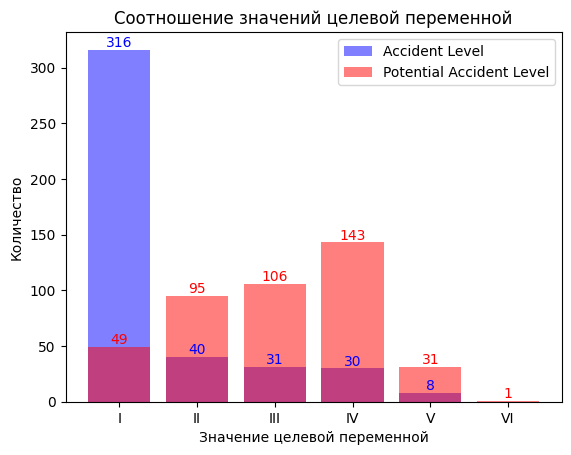

In [7]:
fig, ax = plt.subplots()

# Данные для первого графика
accident_level_counts = df['Accident Level'].value_counts().sort_index()
# Данные для второго графика
potential_accident_level_counts = df['Potential Accident Level'].value_counts().sort_index()

# Первый график (Зелёный прозрачный)
ax.bar(accident_level_counts.index, accident_level_counts, color='blue', alpha=0.5, label='Accident Level')

# Второй график (Красный прозрачный)
ax.bar(potential_accident_level_counts.index, potential_accident_level_counts, color='red', alpha=0.5, label='Potential Accident Level')

plt.title('Соотношение значений целевой переменной')
plt.xlabel('Значение целевой переменной')
plt.ylabel('Количество')

# Подписи для первого графика
for i, value in enumerate(accident_level_counts):
    plt.text(i, value, str(value), ha='center', va='bottom', color='blue')

# Подписи для второго графика
for i, value in enumerate(potential_accident_level_counts):
    plt.text(i, value, str(value), ha='center', va='bottom', color='red')

# Отображение легенды
plt.legend()

plt.show()

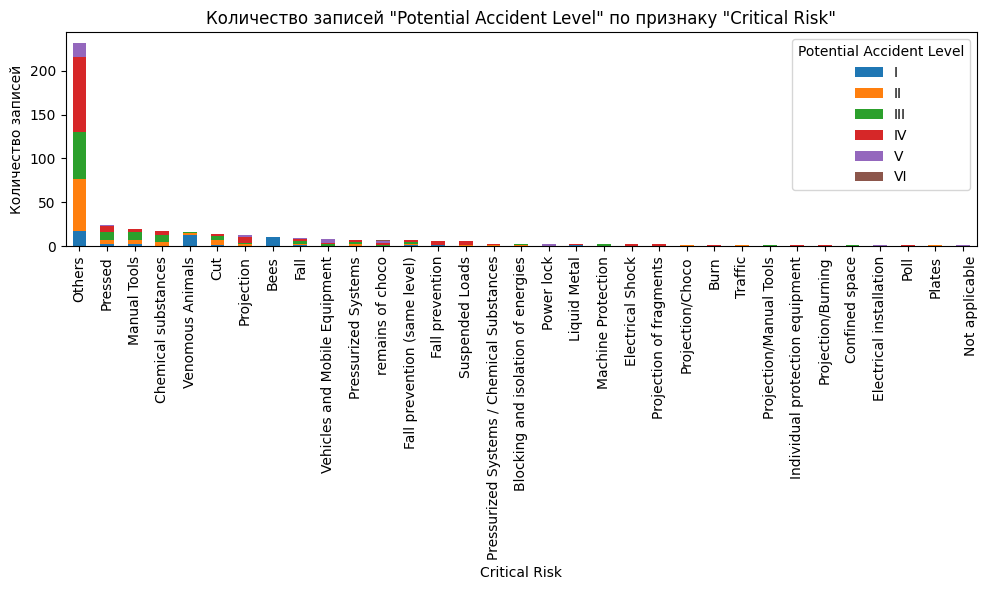

In [8]:
# Группировка данных и подсчет количества записей по признаку "Critical Risk" и уровню "Potential Accident Level"
grouped_data = df.groupby(['Critical Risk', 'Potential Accident Level']).size().unstack(fill_value=0)

# Сортировка по убыванию суммы значений в строках
grouped_data = grouped_data.loc[grouped_data.sum(axis=1).sort_values(ascending=False).index]

# Построение графика
grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))

# Настройка заголовков и меток осей
plt.title('Количество записей "Potential Accident Level" по признаку "Critical Risk"')
plt.xlabel('Critical Risk')
plt.ylabel('Количество записей')
plt.legend(title='Potential Accident Level')
plt.xticks(rotation=90)
plt.tight_layout()

# Отображение графика
plt.show()

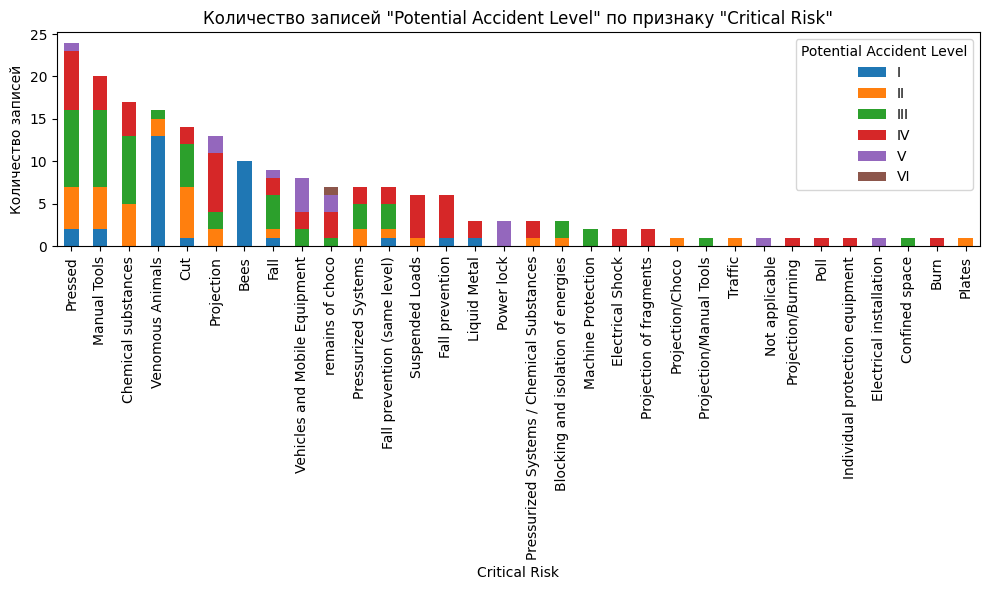

In [9]:
# Фильтрация данных, исключая значение 'Others' в столбце 'Critical Risk'
filtered_df = df[df['Critical Risk'] != 'Others']

# Группировка данных и подсчет количества записей по признаку "Critical Risk" и уровню "Potential Accident Level"
grouped_data = filtered_df.groupby(['Critical Risk', 'Potential Accident Level']).size().unstack(fill_value=0)

# Сортировка по убыванию суммы значений в строках
grouped_data = grouped_data.loc[grouped_data.sum(axis=1).sort_values(ascending=False).index]

# Построение графика
grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))

# Настройка заголовков и меток осей
plt.title('Количество записей "Potential Accident Level" по признаку "Critical Risk"')
plt.xlabel('Critical Risk')
plt.ylabel('Количество записей')
plt.legend(title='Potential Accident Level')
plt.xticks(rotation=90)
plt.tight_layout()

# Отображение графика
plt.show()

Посмотрим распределение происшествий по месяцам.

In [10]:
# Преобразование столбца Data в тип datetime
df['Data'] = pd.to_datetime(df['Data'], format='%Y-%m-%d %H:%M:%S')

# Извлечение названия месяца
df['Month'] = df['Data'].dt.strftime('%B')

Удаляем ненужные колонки.

In [11]:
columns_to_drop = ["Unnamed: 0", "Data", "Countries", "Local", "Industry Sector", "Accident Level",]
df = df.drop(columns=columns_to_drop)

In [12]:
df.head(2)

,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description,Month
0,IV,Male,Third Party,Pressed,"While removing the drill rod of the Jumbo 08 for maintenance, the supervisor proceeds to loosen the support of the intermediate centralizer to facilitate the removal, seeing this the mechanic supports one end on the drill of the equipment to pull with both hands the bar and accelerate the removal from this, at this moment the bar slides from its point of support and tightens the fingers of the mechanic between the drilling bar and the beam of the jumbo.",January
1,IV,Male,Employee,Pressurized Systems,"During the activation of a sodium sulphide pump, the piping was uncoupled and the sulfide solution was designed in the area to reach the maid. Immediately she made use of the emergency shower and was directed to the ambulatory doctor and later to the hospital. Note: of sulphide solution = 48 grams / liter.",January


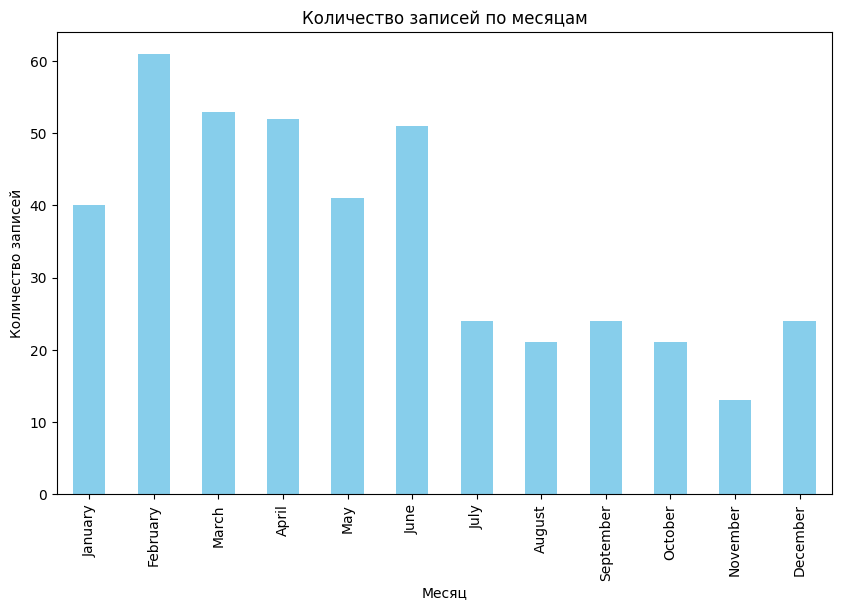

In [13]:
# Создаем словарь с порядком сортировки месяцев
month_order = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

# Выполняем подсчет и сортировку
month_counts = df['Month'].value_counts().sort_index(
    key=lambda x: x.map(month_order)
)

# Создание графика
plt.figure(figsize=(10, 6))  # Размер графика

# Построение столбчатой диаграммы
month_counts.plot(kind='bar', color='skyblue')

# Настройка заголовка и меток осей
plt.title('Количество записей по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество записей')

# Отображение графика
plt.show()

# Нормализуем и почистим текстовое описание происшествий "Description" от имён работников.

In [14]:
# !python -m spacy download en_core_web_sm

In [15]:
# Загружаем модель spaCy для NER и лемматизации
nlp = spacy.load('en_core_web_sm')

# Функция для очистки текста
def clean_description(text):
    doc = nlp(text)
    names = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
    clean_text = text
    for name in names:
        clean_text = re.sub(r'\b' + re.escape(name) + r'\b', '', clean_text)
    
    # Преобразование текста в нижний регистр
    clean_text = clean_text.lower()
    
    # Удаление стоп-слов
    clean_text = ' '.join([word for word in clean_text.split() if word not in STOP_WORDS])
    
    # Удаление коротких слов
    clean_text = ' '.join([word for word in clean_text.split() if len(word) > 2])
    
    # Удаление чисел
    clean_text = re.sub(r'\b\d+\b', '', clean_text)
    
    # Удаление пунктуации
    clean_text = clean_text.translate(str.maketrans('', '', string.punctuation))
    
    return clean_text, names

# Функция для лемматизации текста
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_text = ' '.join([token.lemma_ if token.lemma_ != '-PRON-' else token.text for token in doc])
    return lemmatized_text

# Функция для удаления лишних пробелов
def remove_extra_spaces(text):
    return ' '.join(text.split())

# Применяем функцию ко всему столбцу Description и сохраняем удаленные имена
df['Cleaned_Description'], df['Removed_Names'] = zip(*df['Description'].apply(clean_description))

# Применяем лемматизацию к столбцу с очищенным описанием
df['Cleaned_Description'] = df['Cleaned_Description'].apply(lemmatize_text)

# Удаляем лишние пробелы
df['Cleaned_Description'] = df['Cleaned_Description'].apply(remove_extra_spaces)

# Выводим имена, которые были удалены
for idx, names in enumerate(df['Removed_Names']):
    if names:
        print(f"Row {idx}: Removed names - {names}")

Row 3: Removed names - ['Cristóbal']
Row 4: Removed names - ['Anthony', 'Eduardo', 'Eric Fernández-injured']
Row 5: Removed names - ['Bag']
Row 7: Removed names - ['José', 'Miguel of the EKA Mining']
Row 14: Removed names - ['Waelz']
Row 16: Removed names - ['Jhonatan', 'Nilton']
Row 19: Removed names - ['Manuel', 'Manco', 'José']
Row 20: Removed names - ['Samuel']
Row 21: Removed names - ['Raise']
Row 24: Removed names - ['Mollares', 'Mollares']
Row 32: Removed names - ['Yaranga', 'Juan']
Row 33: Removed names - ['Albertico', 'Jhony', 'Launcher', 'Danon', 'Danon']
Row 47: Removed names - ['bin', 'bin']
Row 48: Removed names - ['Paid']
Row 55: Removed names - ['hose']
Row 56: Removed names - ['Kg']
Row 61: Removed names - ['William de la Cruz', 'Kg', 'William de']
Row 68: Removed names - ['La Laquia']
Row 69: Removed names - ['Simultaneously Jose']
Row 71: Removed names - ['Roy Canario']
Row 75: Removed names - ['Dumper']
Row 78: Removed names - ['Manetometer']
Row 79: Removed names - 

# Перекодируем уровень происшествия в числовые значения и сохраним в новый датасет.

In [16]:
# Создаем объект LabelEncoder
label_encoder = LabelEncoder()

# Применяем LabelEncoder к столбцу 'Potential Accident Level'
df['Potential Accident Level Encoded'] = label_encoder.fit_transform(df['Potential Accident Level']) + 1

# Маппинг значений после кодирования
level_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_) + 1))
print("Mapping for Potential Accident Level:")
print(level_mapping)

Mapping for Potential Accident Level:
{'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5, 'VI': 6}


In [17]:
columns_to_drop = ["Removed_Names", "Description", "Potential Accident Level",]
df = df.drop(columns=columns_to_drop)

In [18]:
# Сохраняем очищенный и нормализованный датасет
df.to_csv('descr_cleaned_dataset.csv', index=False)

# Предобработка датасета для обучения. Вариант 1.

# Выполним One-Hot Encoding для категориальных признаков и векторизацию описания происшествия с использованием TF-IDF.

In [19]:
df = pd.read_csv('descr_cleaned_dataset.csv')

In [20]:
df_copy = df.copy()
df_copy['Cleaned_Description'] = df_copy['Cleaned_Description'].apply(lambda x: (x[:197] + '...') if len(x) > 200 else x)
df_copy.head(2)

,Genre,Employee or Third Party,Critical Risk,Month,Cleaned_Description,Potential Accident Level Encoded
0,Male,Third Party,Pressed,January,remove drill rod jumbo maintenance supervisor proceed loosen support intermediate centralizer facilitate removal see mechanic support end drill equipment pull hand bar accelerate removal this momen...,4
1,Male,Employee,Pressurized Systems,January,activation sodium sulphide pump pipe uncoupled sulfide solution design area reach maid immediately use emergency shower direct ambulatory doctor later hospital note sulphide solution gram liter,4


Применяем One-Hot Encoding с помощью pd.get_dummies

In [21]:
df = pd.get_dummies(df, columns=['Genre', 'Employee or Third Party', 'Critical Risk', 'Month'])

In [22]:
df_copy = df.copy()
df_copy['Cleaned_Description'] = df_copy['Cleaned_Description'].apply(lambda x: (x[:47] + '...') if len(x) > 50 else x)
df_copy.head(2)

,Cleaned_Description,Potential Accident Level Encoded,Genre_Female,Genre_Male,Employee or Third Party_Employee,Employee or Third Party_Third Party,Employee or Third Party_Third Party (Remote),Critical Risk_\nNot applicable,Critical Risk_Bees,Critical Risk_Blocking and isolation of energies,Critical Risk_Burn,Critical Risk_Chemical substances,Critical Risk_Confined space,Critical Risk_Cut,Critical Risk_Electrical Shock,Critical Risk_Electrical installation,Critical Risk_Fall,Critical Risk_Fall prevention,Critical Risk_Fall prevention (same level),Critical Risk_Individual protection equipment,Critical Risk_Liquid Metal,Critical Risk_Machine Protection,Critical Risk_Manual Tools,Critical Risk_Others,Critical Risk_Plates,Critical Risk_Poll,Critical Risk_Power lock,Critical Risk_Pressed,Critical Risk_Pressurized Systems,Critical Risk_Pressurized Systems / Chemical Substances,Critical Risk_Projection,Critical Risk_Projection of fragments,Critical Risk_Projection/Burning,Critical Risk_Projection/Choco,Critical Risk_Projection/Manual Tools,Critical Risk_Suspended Loads,Critical Risk_Traffic,Critical Risk_Vehicles and Mobile Equipment,Critical Risk_Venomous Animals,Critical Risk_remains of choco,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September
0,remove drill rod jumbo maintenance supervisor p...,4,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
1,activation sodium sulphide pump pipe uncoupled ...,4,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


Выполняем векторизацию текста с использованием TF-IDF

In [23]:
# Векторизация текста с использованием TF-IDF
tfidf = TfidfVectorizer(max_features=10000)
X_tfidf = tfidf.fit_transform(df['Cleaned_Description'])

# Преобразование в DataFrame для объединения с исходным датасетом
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [24]:
# Объединение признаков
df = pd.concat([df.drop(columns=['Cleaned_Description']), X_tfidf_df], axis=1)

In [25]:
df.head()

Potential Accident Level Encoded  Genre_Female  Genre_Male  \
0                                 4         False        True   
1                                 4         False        True   
2                                 3         False        True   
3                                 1         False        True   
4                                 4         False        True   

   Employee or Third Party_Employee  Employee or Third Party_Third Party  \
0                             False                                 True   
1                              True                                False   
2                             False                                False   
3                             False                                 True   
4                             False                                 True   

   Employee or Third Party_Third Party (Remote)  \
0                                         False   
1                                         False   
2                                          True   
3                                         False   
4                                         False   

   Critical Risk_\nNot applicable  Critical Risk_Bees  \
0                           False               False   
1                           False               False   
2                           False               False   
3                           False               False   
4                           False               False   

   Critical Risk_Blocking and isolation of energies  Critical Risk_Burn  \
0                                             False               False   
1                                             False               False   
2                                             False               False   
3                                             False               False   
4                                             False               False   

   Critical Risk_Chemical substances  Critical Risk_Confined space  \
0                              False                         False   
1                              False                         False   
2                              False                         False   
3                              False                         False   
4                              False                         False   

   Critical Risk_Cut  Critical Risk_Electrical Shock  \
0              False                           False   
1              False                           False   
2              False                           False   
3              False                           False   
4              False                           False   

   Critical Risk_Electrical installation  Critical Risk_Fall  \
0                                  False               False   
1                                  False               False   
2                                  False               False   
3                                  False               False   
4                                  False               False   

   Critical Risk_Fall prevention  Critical Risk_Fall prevention (same level)  \
0                          False                                       False   
1                          False                                       False   
2                          False                                       False   
3                          False                                       False   
4                          False                                       False   

   Critical Risk_Individual protection equipment  Critical Risk_Liquid Metal  \
0                                          False                       False   
1                                          False                       False   
2                                          False                       False   
3                                          False                       False   
4                             

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Columns: 2461 entries, Potential Accident Level Encoded to zone
dtypes: bool(50), float64(2410), int64(1)
memory usage: 7.8 MB


In [27]:
# Удалим происшествия 6й категрории, т.к. их всего 1 штука.
df = df[df['Potential Accident Level Encoded'] != 6]
df.shape

(424, 2461)

In [28]:
# Выделяем признаки и метки
X = df.drop(columns=['Potential Accident Level Encoded'])
y = df['Potential Accident Level Encoded']

# Разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Обучение. Градиентный бустинг. Вариант 1.

In [36]:
# Определение гиперпараметров для подбора
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5]
}

# Настройка GridSearchCV
gb_clf = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')

# Обучение модели с подбором гиперпараметров
grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Оценка модели с лучшими параметрами
best_gb_clf = grid_search.best_estimator_
y_pred_gb = best_gb_clf.predict(X_test)

# Получение меток классов из y_test
class_labels = sorted(set(y_test))

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 200, 'subsample': 0.8}


In [39]:
# Оценка модели Gradient Boosting
gb_report = classification_report(y_test, y_pred_gb, target_names=[f"{i+1}" for i in class_labels])
print("Gradient Boosting Classification Report:")
print(gb_report)

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.40      0.53        10
           2       0.31      0.21      0.25        19
           3       0.27      0.14      0.19        21
           4       0.45      0.86      0.59        29
           5       0.00      0.00      0.00         6

    accuracy                           0.42        85
   macro avg       0.37      0.32      0.31        85
weighted avg       0.38      0.42      0.37        85



# Обучение. Нейронная сеть. Вариант 1.

Epoch 1/50, Train Loss: 1.7618, Test Loss: 1.5890
Epoch 2/50, Train Loss: 1.5806, Test Loss: 1.5672
Epoch 3/50, Train Loss: 1.5021, Test Loss: 1.5618
Epoch 4/50, Train Loss: 1.3656, Test Loss: 1.5495
Epoch 5/50, Train Loss: 1.3984, Test Loss: 1.5308
Epoch 6/50, Train Loss: 1.3383, Test Loss: 1.5005
Epoch 7/50, Train Loss: 1.2319, Test Loss: 1.4643
Epoch 8/50, Train Loss: 1.1948, Test Loss: 1.4392
Epoch 9/50, Train Loss: 1.1259, Test Loss: 1.4232
Epoch 10/50, Train Loss: 1.0910, Test Loss: 1.4129
Epoch 11/50, Train Loss: 1.0575, Test Loss: 1.3979
Epoch 12/50, Train Loss: 1.0006, Test Loss: 1.3859
Epoch 13/50, Train Loss: 0.9137, Test Loss: 1.3758
Epoch 14/50, Train Loss: 0.8724, Test Loss: 1.3685
Epoch 15/50, Train Loss: 0.7957, Test Loss: 1.3599
Epoch 16/50, Train Loss: 0.7771, Test Loss: 1.3546
Epoch 17/50, Train Loss: 0.7415, Test Loss: 1.3474
Epoch 18/50, Train Loss: 0.6859, Test Loss: 1.3524
Epoch 19/50, Train Loss: 0.6418, Test Loss: 1.3488
Epoch 20/50, Train Loss: 0.6152, Test Lo

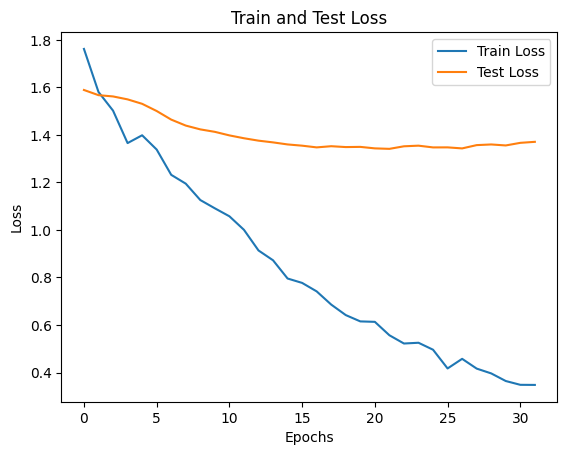

In [42]:
# Преобразование всех столбцов в числовой формат
def convert_to_numeric(df):
    for col in df.columns:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(int)
        elif df[col].dtype == 'object':
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                df[col] = pd.factorize(df[col])[0]
    return df

# Выделяем признаки и метки
X = df.drop(columns=['Potential Accident Level Encoded'])
y = df['Potential Accident Level Encoded']

# Преобразование всех данных в числовой формат
X = convert_to_numeric(X)

# Разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Преобразование меток классов в диапазон от 0 до num_classes-1
y_train = y_train - 1
y_test = y_test - 1

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Создание DataLoader для PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Определение модели нейронной сети
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)  # уменьшение размера скрытого слоя
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)
        self.dropout = nn.Dropout(0.6)  # увеличение dropout
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size // 2)

    def forward(self, x):
        out = self.fc1(x)
        out = self.batch_norm1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.batch_norm2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out

input_size = X_train.shape[1]
hidden_size = 128  # уменьшение скрытого слоя
num_classes = len(y.unique())

model = MLP(input_size, hidden_size, num_classes)

# Определение функции потерь и оптимизатора с L2-регуляризацией
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)  # уменьшение learning rate и увеличение weight decay

# Обучение модели с ранним прекращением
num_epochs = 50
train_losses = []
test_losses = []
best_test_loss = float('inf')
patience = 10  # Число эпох без улучшений перед остановкой
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_losses.append(train_loss / len(train_loader))

    # Проверка на тестовом наборе
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    # Раннее прекращение
    if test_losses[-1] < best_test_loss:
        best_test_loss = test_losses[-1]
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered.")
        break

# Оценка модели
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend((predicted + 1).numpy())  # Сдвиг предсказанных значений на +1
        y_true.extend((y_batch + 1).numpy())    # Сдвиг истинных значений на +1 для правильного сравнения

# Проверка на переобучение и недообучение
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Loss')
plt.show()

In [43]:
# Оценка модели Gradient Boosting
# gb_report = classification_report(y_test, y_pred_gb)
print("Gradient Boosting Classification Report:")
print(gb_report)

# Отчет о классификации
report = classification_report(y_true, y_pred)
print("Neural Network Classification Report:")
print(report)

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.40      0.53        10
           2       0.31      0.21      0.25        19
           3       0.27      0.14      0.19        21
           4       0.45      0.86      0.59        29
           5       0.00      0.00      0.00         6

    accuracy                           0.42        85
   macro avg       0.37      0.32      0.31        85
weighted avg       0.38      0.42      0.37        85

Neural Network Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.70      0.82        10
           2       0.39      0.47      0.43        19
           3       0.31      0.43      0.36        21
           4       0.43      0.34      0.38        29
           5       0.67      0.33      0.44         6

    accuracy                           0.44        85
   macro avg       0.56      0.46      0.49        8

# Предобработка датасета для обучения. Вариант 2.

<h3>Для каждого класса собирём все описания происшествий в единый текст, затем определим из этого текста:</h3> 
<br>1. Должность.
<br>2. Действия, которые совершал работник.
<br>3. Инструменты и техника.

Добавим эти данные для каждой строки соответствующего класса в датасете (создадим новые поля).

In [44]:
df = pd.read_csv('descr_cleaned_dataset.csv')

In [45]:
# Группировка описаний по категориям
grouped = df.groupby('Potential Accident Level Encoded')['Cleaned_Description'].apply(lambda x: ' '.join(x)).reset_index()
grouped.to_excel('c:/Users/AADementev/Desktop/Projects/python/MachineLearning/graduation_project_pro/grouped_descriptions.xlsx', index=False)

In [46]:
grouped.head(1)

Potential Accident Level Encoded  \
0                                 1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [47]:
grouped_descriptions = dict(zip(grouped['Potential Accident Level Encoded'], grouped['Cleaned_Description']))

In [ ]:
# # Преобразование словаря в список документов
# documents = list(grouped_descriptions.values())
# categories = list(grouped_descriptions.keys())

In [ ]:
# # Функция для преобразования части речи
# def get_wordnet_pos(word):
#     tag = nltk.pos_tag([word])[0][1][0].upper()
#     tag_dict = {"J": wordnet.ADJ,
#                 "N": wordnet.NOUN,
#                 "V": wordnet.VERB,
#                 "R": wordnet.ADV}
#     return tag_dict.get(tag, wordnet.NOUN)

# # Функция для лемматизации текста и извлечения только существительных и глаголов
# lemmatizer = WordNetLemmatizer()
# def lemmatize_and_filter(text):
#     words = word_tokenize(text)
#     pos_tags = nltk.pos_tag(words)
#     filtered_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) 
#                       for word, pos in pos_tags if pos.startswith('N') or pos.startswith('V')]
#     return ' '.join(filtered_words)

# # Применение фильтрации и лемматизации к описаниям
# df['Cleaned_Description'] = df['Cleaned_Description'].apply(lemmatize_and_filter)

# # Группировка описаний по категориям
# grouped = df.groupby('Potential Accident Level Encoded')['Cleaned_Description'].apply(lambda x: ' '.join(x)).reset_index()

# # Создание признаков из описаний
# tfidf = TfidfVectorizer(stop_words='english')
# tfidf_matrix = tfidf.fit_transform(grouped['Cleaned_Description'])
# tfidf_feature_names = tfidf.get_feature_names_out()

# # Преобразование в DataFrame
# tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=grouped['Potential Accident Level Encoded'], columns=tfidf_feature_names)

# # # Функция для получения топ-50 слов по каждой категории
# # def get_top_n_words(tfidf_df, category, n=50):
# #     row = tfidf_df.loc[category]
# #     top_n_words = row.sort_values(ascending=False).head(n)
# #     return top_n_words

# # # Вывод топ-50 слов для каждой категории
# # top_words_by_category = defaultdict(list)
# # for category in tfidf_df.index:
# #     top_words = get_top_n_words(tfidf_df, category)
# #     top_words_by_category[category] = top_words

# # # Печать топ-50 слов для каждой категории
# # for category, top_words in top_words_by_category.items():
# #     print(f"Top 50 words for category '{category}':")
# #     print(top_words)
# #     print("\n")

In [ ]:
# # Определение количества категорий
# num_categories = len(top_words_by_category)

# # Создание сетки 3x2
# fig, axes = plt.subplots(2, 3, figsize=(25, 20))

# # Проход по категориям и создание графиков
# for ax, (category, top_words) in zip(axes.flatten(), top_words_by_category.items()):
#     ax.barh(top_words.index, top_words.values, color='skyblue')
#     ax.set_xlabel('TF-IDF Score')
#     ax.set_ylabel('Words')
#     ax.set_title(f'Сategory {category}')
#     ax.invert_yaxis()  # Инвертируем ось Y для лучшего отображения

# # Удаление пустых подграфиков, если категорий меньше 6
# for i in range(num_categories, 6):
#     fig.delaxes(axes.flatten()[i])

# plt.tight_layout()
# plt.show()

<h3>Попробуем сделать автоматическую выборку должностей, действий и минструментов с помощью библиотеки spaCy для обработки естественного языка (NLP).</h3>

In [48]:
# Загружаем модель для обработки текста на английском языке
nlp = spacy.load("en_core_web_sm")

# Текст
text = """
be approximately nv cx ob7 personnel begin task unlock soquet bolt bhb machine penultimate bolt identify hexagonal head wear proceed mr auxiliary assistant climb platform exert pressure hand dado key prevent come bolt moment collaborator rotate lever anticlockwise direction leave key bolt hit palm leave hand cause injury collaborator report work ustulación realize cyclone duct obstruct open door try unclog material detach project employee cause small burn right heel end lunch enable place winche control room get short walk slip sit floor make contact leave knee take importance rest guard guard finish go safety communicate fact reason derive natclar attention trip vehicle end work collaborator step object identify come pierce sole boot cause small hole sole left foot collaborator perforation possibly stump wood area cover collaborator pasture graze recently near residence perform geological mapping activity necessary hammer rock analysis moment clerk hold it point fragment slip quirodactyl right hand cause superficial cut circumstance collaborator perform washing tabolas pot washing area suffer feel dizziness faintness cause fall level produce slight concussion head ground team coordinate prospector assistant wila pm prong opening access collect soil sample come try divert meter right place moment diversion come marimbondo house he give time action thug agitate time ste head neck sting face allergy test verify allergic reaction wash affect return normal activity geological reconnaissance activity farm mr team compose felipe normal activity encounter ciliary forest need enter forest verify rock outcrop front divine realize open access machete moment take bite neck attack allergic reaction continue work normally work complete leave forest access divine assistant attack snake suffer sting forehead moment move away area verify type allergic reaction return normal activity geological reconnaissance activity farm mr team compose felipe normal activity encounter ciliary forest need enter forest verify rock outcrop front divine realize open access machete moment take bite neck attack allergic reaction continue work normally work complete leave forest access divine assistant attack snake suffer sting forehead moment move away area verify type allergic reaction return normal activity employee work electrician management electrometallurgy suffer contusion right leg suffer slip height step staircase code ele abb furnace cat ladder immediately refer collaborator medical service treat circumstance employee connection electric cable no jumbo operator feel discomfort face clean hand rubber glove generate superficial laceration small wound leave cheekbone project vazante carry sediment collection current south mata target drainage serra garrote team compose member wca company move collection point another inside shallow drainage see bee carton reaction away box quickly possible avoid sting run meter look safe area exit radius attack bee ss breno attack consequently suffer sting belly hand verify type allergic reaction return normal activity project vazante carry sediment collection current south mata target drainage serra garrote team compose member wca company move collection point another inside shallow drainage see bee carton reaction away box quickly possible avoid sting run meter look safe area exit radius attack bee ss breno attack consequently suffer sting belly hand verify type allergic reaction return normal activity geologo auxiliary travel evaluate geological point follow gps near drainage follow state highway give access area stop get vehicle point identify gps distance seven meter vehicle follow road surprised bite thorn face neck quickly hurried vehicle move away place clerk wear girdle goggle wear glove enter forest area allergic reaction geologist auxiliary travel field evaluate geological point follow gps near drainage follow state highway give access area stop get vehicle point identify gps mário distancing meter vehicle follow road surprised bite thorn face quickly hurried vehicle move away place clerk wear girdle goggle wear glove enter forest area allergic reaction safety technical move field inspection activity way field pause team order know drainage point check safety get vehicle strike sting weed neck quickly return vehicle radio communication team distance place clerk wear legging glass allergic reaction auxiliary travel field evaluate geological point follow gps near drainage follow state highway give access area stop get vehicle point identify gps distancing meter vehicle accompany geologist surprised bite blow neck quickly hurried vehicle move away place clerk wear girdle goggle wear glove enter forest area allergic reaction travel field order geological mapping geologist accompany prospector stoop deviate vegetation time receive whistling sting they face neck allergic reaction activity follow normally event move field geological mapping prospector accompany geologist stoop deviate vegetation moment receive whistle sting ring finger right hand allergic reaction activity follow normally event mince team carry activity city juína coordinate mining technician felipe time mining technician line away team bite blackjack leave face allergic manifestation team continue work afternoon lunch employee seek medical care medicate release continue activity day level unicon plant collaborator shuttering work concrete water sedimentation basin moment nail wood supply inch strip feel metallic hammer loosen wooden handle fix it grab hammer head hit handle vertically wood generating injury time accident employee use safety glove cut vegetation open bite sickle assistant strike vine twice liana ruptured branch project face auxiliary cause cut upper lip collaborator be clean leave return borehole brapdd slip canva edge well hit right metal structure mudswathe box cause slight excoriation employee refer local hospital medicate release activity be approximately mechanic remove bolt nipple pump lime feeder reactive area mechanic position slightly flex leg perform upward force hand moment feel pain spume right thigh mechanic evacuate help colleague medical post region povoado vista martinópole ce employee perform soil collection activity field auxiliary diassis nascimento be cross fence glove attach wire body project forward cause slight twist leave wrist team travel city granja employee refer hospital consultation doctor diagnose fracture prescribing remedy local pain ice pack medical evaluation employee carry activity normally level dining room collaborator finish wash tabolas food container dimension cm proceed order pink thumb right hand corner aluminum tabola generating lesion employee time accident safety glove preparation scaffold activity employee loading piece designate place finger press metal piece move employee engage removal material excavation level shovel placing bucket day material fall pipe employee boot friction boot calf cause superficial injury leg employee engage removal material excavation level shovel placing bucket day material fall pipe employee boot friction boot calf cause superficial injury leg be activity collect soil collaborator run branch attack maribondo bite twice head pain swell allergic symptom continue activity activity package cylindrical piece easel employee carry piece designate place finger press metal piece move perform carpentry work collaborator hit second finger leave hand hammer hold right hand cause bruise height nail evaluation carry medical center unit final diagnosis contusion finger pm perform magnetometric gps collaborator bump field hat branch attack maribondo bitten ear shoulder continued activity feel pain swelling pm assist gps magnetometric collaborator bump field hat branch attack maribondo moth go eye use sunglass attack region prevent insect move face getting catch ear field hat make helper bite ear allergic marimbondo bite soon activity immediately paralyze drove car accident take medicine antiallergic situation work indicate doctor avoid swell responsible project field mapping activity call radio immediately assistant feel good take emergency hospital lavra sul consult doctor take antiallergic release carry refractory brick chop activity order place support bus bar section particle detach hit assistant right arm meter away work area provoke wound arm treat medical center return usual duty soil sample region employee danillo silva attack bee test rush away place employee take bite chin chest neck hand glove employee take bite hand glove head employee danillo take bite leave arm uniform sketch allergy swell ste site activity stop evaluate site verifying test remain line leave site soil sample region employee danillo silva attack bee test rush away place employee take bite chin chest neck hand glove employee take bite hand glove head employee danillo take bite leave arm uniform sketch allergy swell ste site activity stop evaluate site verifying test remain line leave site soil sample region employee danillo silva attack bee test rush away place employee take bite chin chest neck hand glove employee take bite hand glove head employee danillo take bite leave arm uniform sketch allergy swell ste site activity stop evaluate site verifying test remain line leave site pm perform mag activity employee move acquisition line come small drainage approximately 40 cm wide small gap traverse drainage employee rest right foot ravine come rest cause right ankle twist soon twist activity paralyze employee take local hospital xray take examination physician injury find small swelling release normal activity team vms project perform soil collection xixás target members team move collection point another mr ahead team sting near collection point surprised swarm bee inside play near ground visibility wood hiss noise pass stump attack bee ste left arm uniform prick lip screen rip tangle branch escape team vms project perform soil collection xixás target members team move collection point another mr ahead team sting near collection point surprised swarm bee inside play near ground visibility wood hiss noise pass stump attack bee ste left arm uniform prick lip screen rip tangle branch escape technician magnetometric survey step thorn reaction immediately retreat lose balance magnetometer antenna break 30hs current sediment activity collaborator take bee ste neck screen bee enter screen sting team decide leave workplace presence bee collaborator reaction continue work normally execution soil sample task potion area pm open machete bite wasp right hand time incident epi needed activity employee evaluate technician find mild localize swelling wound employee report feel pain continue activity execution service opening prick future work ip employee line equipment sting wasp right portion neck beetle small size see employee bite cause employee shock insect manifest employee ppe require activity develop bite occur collar shirt face shield technician responsible performing work evaluate ste and injure employee find localized swell allergy need paralyze activity follow normally execution soil sample task potion area pablo move bite bite right elbow wasp sleeve uniform time incident ppe need activity employee evaluate team find mild injury localize swell employee report feel pain continue activity employee pass corner door see virdro slight swell frontal region closing glass door activity maintenance scaller breaker arm extension cylinder local underground level removal cylinder scaller arm releasing fix pin cylinder come down bump tool press hand tool structure equipment field activity amg project target reconnaissance team boarding car park window close enter mr put seat belt inside vehicle press wasp shoulder neck cause sting believe that possibly bee nail clothe car properly close
"""

# Функция для извлечения должностей
def extract_positions(text):
    positions = set()
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ in ["PERSON", "ORG"]:
            positions.add(ent.text)
    return list(positions)

# Функция для извлечения оборудования и инструментов
def extract_equipment(text):
    equipment = set()
    doc = nlp(text)
    for token in doc:
        if token.pos_ == "NOUN":
            equipment.add(token.text)
    return list(equipment)

# Функция для извлечения действий
def extract_actions(text):
    actions = set()
    doc = nlp(text)
    for token in doc:
        if token.pos_ == "VERB":
            actions.add(token.lemma_)
    return list(actions)

# Извлечение данных
positions = extract_positions(text)
equipment = extract_equipment(text)
actions = extract_actions(text)

# Вывод результатов
print("Должности:")
print(positions)
print("\nДействия:")
print(actions)
print("\nОборудование и инструменты:")
print(equipment)

Должности:
['bee ss', 'city juína', 'vista', 'maribondo moth', 'meter vehicle', 'ppe', 'prick future', 'slip canva']

Действия:
['cheekbone', 'ear', 'believe', 'need', 'exert', 'quirodactyl', 'evaluate', 'pump', 'face', 'obstruct', 'identify', 'handle', 'begin', 'stop', 'receive', 'break', 'occur', 'feel', 'use', 'localize', 'refer', 'procee', 'develop', 'make', 'cover', 'find', 'enable', 'pierce', 'remain', 'release', 'legge', 'move', 'escape', 'slip', 'geologo', 'decide', 'engage', 'come', 'avoid', 'provoke', 'wear', 'produce', 'encounter', 'see', 'work', 'require', 'know', 'run', 'grab', 'pass', 'surprise', 'treat', 'give', 'leave', 'bite', 'drive', 'level', 'retreat', 'stoop', 'perform', 'generate', 'try', 'injure', 'enter', 'realize', 'loosen', 'play', 'verify', 'look', 'carry', 'return', 'get', 'help', 'shield', 'go', 'cut', 'hit', 'thorn', 'stump', 'suffer', 'consult', 'ste', 'assist', 'cause', 'paralyze', 'compose', 'swell', 'seek', 'indicate', 'derive', 'hold', 'collect', 'con

Как видим результаты не очень точные.

<h3>Выполним сбор данных вручную.</h3>

In [49]:
df = pd.read_csv('descr_cleaned_dataset.csv')

In [51]:
df.head(2)

,Genre,Employee or Third Party,Critical Risk,Month,Cleaned_Description,Potential Accident Level Encoded
0,Male,Third Party,Pressed,January,remove drill rod jumbo maintenance supervisor proceed loosen support intermediate centralizer facilitate removal see mechanic support end drill equipment pull hand bar accelerate removal this moment bar slide point support tighten finger mechanic drilling bar beam jumbo,4
1,Male,Employee,Pressurized Systems,January,activation sodium sulphide pump pipe uncoupled sulfide solution design area reach maid immediately use emergency shower direct ambulatory doctor later hospital note sulphide solution gram liter,4


In [52]:
# Создаем словарь с данными для таблицы
data = {
    "Должности": [
        "Auxiliary assistant, Collaborator, Clerk, Geologist, Safety technical, Mining technician, Mechanical, Danilo Silva, Technician.", 
        "Forklift operator, Collaborator, Operator, Chief guard, Assistant, Engineer trainee, Teacher, Store attendant, Welder, Topographic surveyor, Operator bolter, Technician, Mixkret operator, Geologist, Maintenance team, Mechanic, Surveying worker, Industrial cleaning worker, Food preparer, Mobile equipment maintenance team, Comedor worker.", 
        "Collaborator, Mechanic technician, Electrician supervisor, Master loader, Equipment assistant, Official operator, Assistant loader, Master shipper, Truck crane operator, Mechanic, Technician, Civil operator, Bolted assistant, Welder, Helper, Boltec technician, Sampler, Electrician, Operator, Mechanic operator.", 
        "Maintenance Supervisor, Mechanic, Driller assistant, Operator, Mason Assistant, Bolter Operator, Mill Operator, Assistant Mechanic, Welder, Technician, Truck Driver, Plant Worker, Blaster, Maintenance worker.", 
        "Mixkret operator, Resident engineer, Filter operator, Autoclave operator, Mechanic, Pilot, Mixer operator, Wheel loader operator, Operator of the concrete plant, Scalar operator."
    ],
    "Должности (пример на русском)": [
        "Геолог, Горный техник-технолог.", 
        "Оператор вилочного погрузчика, Оператор горно-шахтной самоходной машины.", 
        "Техник-механик, Оператор автокрана.",
        "Помощник по бурению, Взрыватель.", 
        "Пилот, Оператор фронтального погрузчика, Оператор бетономешалки, Оператор горно-шахтной самоходной машины, Механик."
    ],
    "Действия": [
        "Unlock, Identify hexagonal head, Climb platform, Exert pressure hand, Try unclog material, Detach project, Enable place winch control room, Get short walk slip, Sit floor, Make contact, Carry sediment collection, Run meter, Evaluate geological point, Give access area, Know drainage point, Strike sting weed neck, Perform soil collection activity, Attach wire, Perform magnetometric GPS, Use sunglass, Carry refractory brick, Chop activity, Place support bus bar section, Execute soil sample task, Open machete, Break magnetometer Antenna, Move acquisition line, Traverse drainage.", 
        "Cleaning metal structures, Operating a crane and forklift, Using a hammer and chisel, Releasing a blade and manually displacing sheets, Operating a truck and adjusting bolts, Cutting electro welded mesh, Opening access areas with tools, Welding and inspecting mining cars, Handling chemicals, Performing maintenance on various equipment, Using a torch for cutting activities, Loading and unloading materials, Preparing geological maps and conducting surveys, Painting floors, Carrying out inspections, Preparing food, Cleaning industrial areas, Handling ventilation equipment.", 
        "Excavation work, Unload operation, Unclog discharge mouth, Maneuver to unhook hose, Turn pulley manually, Grab transmission belt, Verify belt tension, Install segment of polyurethane pulley, Clean shutter with air lance, Perform truck unload operation, Remove rope tie, Perform disconnection of power cable, Detach upper support point, Verify remaining position, Identify rock mesh, Change drill bit, Release coupling, Replace telescopic expansion joint, Position portable ladder, Hold base of loader, Clean spatula spear window boiler, Perform radial drilling, Activate hydraulic pump inspection cover, Install support mesh cloth, Handle water supply hose, Verify lock failure, Dismantle scaffold, Perform carbon steel pipe mark activity, Perform maintenance on motor support, Place protective plate on fuel tank, Perform supply operation for zinc powder container, Perform maintenance activity on transmission belt, Test soft starter engine belt, Perform mechanical support activity, Conduct inspection of sulfuric acid spill line, Carry out sand electrolysis piece, Perform brushcutter operation, Handle pneumatic conveyor, Transport dust zinc container, Lower metal sheet, Assemble activity for polypropylene pipe, Clean area near conveyor, Move locomotive personnel, Perform drilling activity with LM17 probe, Remove bucket of pulp sample, Supervise ustulation activity, Carry inspection cut block level OB6A.", 
        "Loosening support, Facilitating removal, Tightening, Activating pump, Designing area, Applying aid, Positioning pot, Operating drill, Cleaning position, Securing pipe, Lifting platform, Aligning cathode press, Manually moving steel cabinet, Drilling hole, Removing flange, Applying shotcrete, Preparing oil cylinder, Mounting rail platform, Feeding bag into furnace, Supporting stabilizer, Conducting maintenance, Checking work front, Verifying ventilation, Placing mesh, Pulling support mesh, Unloading ore, Reshaping hand, Unlocking rod, Tightening bolt, Evaluating acid leakage, Unloading residual water, Operating equipment, Driving truck, Inspecting equipment, Removing suction pipe, Cleaning low floor, Wearing safety equipment, Entering filter belt, Preparing construction, Perform rock untie, Lift brace, Hoisting and setting up equipment, Changing fuses, Soil collection, Cleaning area, Installation of ventilation plug, Welding steel plate, Unloading material, Operating overflow system, Manipulating hose, Testing equipment.", 
        "Open the electric board, Proceed with the installation, Remove the lock, Use the thermomagnetic key, Make phase contact, Check voltage, Plug socket, Cut wire, Transfer pump, Clean pump, Manipulate motor pump transmission, Change cable, Start equipment, Stop equipment, Perform sanitation, Clean compressor, Lubricate equipment, Load explosive equipment, Putty work, Clean material, Change conveyor belt."
    ],
    "Действия (пример на русском)": [
        "Крепление провода, Установка опорной шины, Отбор пробы почвы, Включение пункта управления лебёдкой, Прокладка дренажа.", 
        "Очистка металлических конструкций, Управление краном и вилочным погрузчиком, Сварка и осмотр карьерных машин, Погрузка и разгрузка материалов, Использование горелки для резки материалов.", 
        "Разгрузка грузовика, Радиальное бурение, Отсоединение кабеля питания, Разъединение муфты, Замена телескопического компенсатора.", 
        "Установка резервуара, Монтаж рельсовой платформы, Подготовка масляного баллона, Подача мешка в печь, Установка стабилизатора.", 
        "Проверка напряжения, Очистка насоса, Замена кабеля, Очистка компрессора, Загрузка взрывоопасного оборудования, Замена ленты конвейера."
    ],
    "Инструменты и техника": [
        "Metal piece, Shovel, Bucket, Canvas, Wooden handle, Metallic hammer, Sickle, Electric cable, Magnetometric GPS, Antenna, Hammer, Rock, Machete, Refractor, Shovel, Tabola, Scaller breaker arm, Hand tool, Structure equipment, Magnetometer, Screen.", 
        "Forklift, Hammer and chisel, Ladder, Manual displacement tools, Truck (A30), Electro welded mesh cutter, Machete, Welding equipment, Mixing equipment, Loaders (e.g., J005A), Sludge lever, Shears, Scissor bolter, Mona car, Laboratory sampling tools, Chemical containers, Pressure hoses, Pumps and blowers, Mining and inspection tools, High-pressure pump gun, Shovels and cleaning tools, Power cables and sockets, Cathode cranes, Zinc sheets, Wooden stumps, Rail tracks and corridors, Industrial cleaning equipment, Soil activity tools (e.g., pickaxe).", 
        "Ustilago powder, Silo truck, Transmission belt HM pump, Polyurethane pulley, Electro welded mesh, Hydraulic cylinder, Winch pulley, Air lance, Telescopic ladder, Metal bar hammer, Telescopic expansion joint HDPE pipe, Spatula spear window boiler, Simba M4C ITH equipment, Hydraulic pump, Volumetric balloon, Radial drilling machine, Scissor bolter, HDPE pipe storm drainage system, POM D071 return thickener, LM17 probe, Iron bundle truck, Breaker tip, Jumbo drilling rig, Stilson key, Tire lever, Sledgehammer, Doosan RB equipment, Combination wrench, Hydraulic load maintenance equipment, Mechanized support scissor, Shotcrete gun, Three-way pear pipette, Nitrogen hose, Hydraulic fill pipe.", 
        "Drill rod, Jumbo, Sodium sulphide pump, Hand bar, Pulley motor, Oil cylinder, Scaffold, Truck, Bolt, Drilling machine, Stilson key, Steel wire rope, Winch, Jack, Suction valve, Cable pump, Locomotive, Electrical system, Shotcrete equipment, Ingot rotary table, Air lance, Concrete throwing team, Geho pump, Metal rake, Hydraulic hammer, Chisel, Lubricant, Strip set, Mining car, Diamond drill, Fisherman winch cable, Calibrator, Welding equipment, Peristaltic pump, Tirfor, Autoclave, Conveyor belt, Ventilation plug, Cleaning mechanism, Water hose, Manipulator, Stone cutting machine, Scoop lip, Hoist, Jackleg.", 
        "Split set intersection, Electric board 440V 400A, Thermomagnetic key, Panel shell, Mixkret, Autoclave, Anfo loader, Dumper, Pump, Automatic sampler, Platform, Wheel loader, Manual tick, Hydraulic fill, Intermediate cardan protector, Lamp, Motor transmission belt, Compressor, Cross cutter, Conveyor belt, Suction spool, Scrubber, Hydraulic cylinder, Vibrator, Scoop, Electric cable, PVC pipe, Fan belt, Key, Hose, Shotcrete."
    ],
    "Инструменты и техника (пример на русском)": [
        "Молоток, Лопата, Скобозабивной станок, Магнитометр.", 
        "Сварочное оборудование, Автомобиль, Насосы и воздуходувки, Инструменты для горных работ и инспекции, Силовые кабели и розетки.", 
        "Гидравлический цилиндр, Отбойный молоток, Радиально-сверлильный станок, Гидравлический насос, Тележка для перевозки рулонов железа.", 
        "Насос для перекачки сульфида натрия, Локомотив, Шкив двигателя, Поворотный стол для обработки слитков, Оборудование для торкретирования бетона, Камнерезный станок.", 
        "Электрическая панель 440V 400A, Горно-шахтная самоходная машина, Конвейерная лента, Ремень вентилятора, Самосвал-погрузчик."
    ]
}

# Создаем DataFrame
df_descr = pd.DataFrame(data, index=["1 уровень", "2 уровень", "3 уровень", "4 уровень", "5 уровень"])

# Настраиваем стили для выравнивания текста и заголовков
styled_df = df_descr.style.set_properties(**{
    'text-align': 'left',
    'vertical-align': 'top'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center'), ('vertical-align', 'top')]},
    {'selector': 'td', 'props': [('text-align', 'left'), ('vertical-align', 'top')]}
])

# Преобразуем стилизованный DataFrame в HTML и выводим в Jupyter Notebook
html = styled_df.to_html()

# Отображаем HTML
display(HTML(html))

,Должности,Должности (пример на русском),Действия,Действия (пример на русском),Инструменты и техника,Инструменты и техника (пример на русском)
1 уровень,"Auxiliary assistant, Collaborator, Clerk, Geologist, Safety technical, Mining technician, Mechanical, Danilo Silva, Technician.","Геолог, Горный техник-технолог.","Unlock, Identify hexagonal head, Climb platform, Exert pressure hand, Try unclog material, Detach project, Enable place winch control room, Get short walk slip, Sit floor, Make contact, Carry sediment collection, Run meter, Evaluate geological point, Give access area, Know drainage point, Strike sting weed neck, Perform soil collection activity, Attach wire, Perform magnetometric GPS, Use sunglass, Carry refractory brick, Chop activity, Place support bus bar section, Execute soil sample task, Open machete, Break magnetometer Antenna, Move acquisition line, Traverse drainage.","Крепление провода, Установка опорной шины, Отбор пробы почвы, Включение пункта управления лебёдкой, Прокладка дренажа.","Metal piece, Shovel, Bucket, Canvas, Wooden handle, Metallic hammer, Sickle, Electric cable, Magnetometric GPS, Antenna, Hammer, Rock, Machete, Refractor, Shovel, Tabola, Scaller breaker arm, Hand tool, Structure equipment, Magnetometer, Screen.","Молоток, Лопата, Скобозабивной станок, Магнитометр."
2 уровень,"Forklift operator, Collaborator, Operator, Chief guard, Assistant, Engineer trainee, Teacher, Store attendant, Welder, Topographic surveyor, Operator bolter, Technician, Mixkret operator, Geologist, Maintenance team, Mechanic, Surveying worker, Industrial cleaning worker, Food preparer, Mobile equipment maintenance team, Comedor worker.","Оператор вилочного погрузчика, Оператор горно-шахтной самоходной машины.","Cleaning metal structures, Operating a crane and forklift, Using a hammer and chisel, Releasing a blade and manually displacing sheets, Operating a truck and adjusting bolts, Cutting electro welded mesh, Opening access areas with tools, Welding and inspecting mining cars, Handling chemicals, Performing maintenance on various equipment, Using a torch for cutting activities, Loading and unloading materials, Preparing geological maps and conducting surveys, Painting floors, Carrying out inspections, Preparing food, Cleaning industrial areas, Handling ventilation equipment.","Очистка металлических конструкций, Управление краном и вилочным погрузчиком, Сварка и осмотр карьерных машин, Погрузка и разгрузка материалов, Использование горелки для резки материалов.","Forklift, Hammer and chisel, Ladder, Manual displacement tools, Truck (A30), Electro welded mesh cutter, Machete, Welding equipment, Mixing equipment, Loaders (e.g., J005A), Sludge lever, Shears, Scissor bolter, Mona car, Laboratory sampling tools, Chemical containers, Pressure hoses, Pumps and blowers, Mining and inspection tools, High-pressure pump gun, Shovels and cleaning tools, Power cables and sockets, Cathode cranes, Zinc sheets, Wooden stumps, Rail tracks and corridors, Industrial cleaning equipment, Soil activity tools (e.g., pickaxe).","Сварочное оборудование, Автомобиль, Насосы и воздуходувки, Инструменты для горных работ и инспекции, Силовые кабели и розетки."
3 уровень,"Collaborator, Mechanic technician, Electrician supervisor, Master loader, Equipment assistant, Official operator, Assistant loader, Master shipper, Truck crane operator, Mechanic, Technician, Civil operator, Bolted assistant, Welder, Helper, Boltec technician, Sampler, Electrician, Operator, Mechanic operator.","Техник-механик, Оператор автокрана.","Excavation work, Unload operation, Unclog discharge mouth, Maneuver to unhook hose, Turn pulley manually, Grab transmission belt, Verify belt tension, Install segment of polyurethane pulley, Clean shutter with air lance, Perform truck unload operation, Remove rope tie, Perform disconnection of power cable, Detach upper support point, Verify remaining position, Identify rock mesh, Change drill bit, Release coupling, Replace telescopic

In [53]:
# Проверка наличия строк с Potential Accident Level Encoded = 6
count_6 = df[df['Potential Accident Level Encoded'] == 6].shape[0]
print(f'Количество строк с Potential Accident Level Encoded = 6: {count_6}')

# Удаление всех строк с Potential Accident Level Encoded = 6
df = df[df['Potential Accident Level Encoded'] != 6]

# Проверка количества строк после удаления
print(f'Количество строк после удаления: {df.shape[0]}')

# Проверка информации о DataFrame
print(df.info())

Количество строк с Potential Accident Level Encoded = 6: 1
Количество строк после удаления: 424
<class 'pandas.core.frame.DataFrame'>
Index: 424 entries, 0 to 424
Data columns (total 6 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Genre                             424 non-null    object
 1   Employee or Third Party           424 non-null    object
 2   Critical Risk                     424 non-null    object
 3   Month                             424 non-null    object
 4   Cleaned_Description               424 non-null    object
 5   Potential Accident Level Encoded  424 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 23.2+ KB
None


<h3>Создадим новые колонки и сохраним датасет.</h3>

In [54]:
# Создание новых колонок на основе значения "Potential Accident Level Encoded"
def map_data(level):
    return {
        "Positions": data["Должности"][level-1],
        "Actions": data["Действия"][level-1],
        "Tools_and_equipment": data["Инструменты и техника"][level-1]
    }

# Применяем функцию к каждому значению в колонке "Potential Accident Level Encoded"
mapped_data = df['Potential Accident Level Encoded'].apply(map_data)

# Преобразуем Series of dicts в DataFrame
mapped_df = pd.DataFrame(mapped_data.tolist())

# Объединяем оригинальный DataFrame с новым DataFrame
result_df = pd.concat([df.reset_index(drop=True), mapped_df], axis=1)

# Сохранение нового датасета в файл
result_df.to_csv('df_pos_act_tools.csv', index=False)

In [55]:
df = pd.read_csv('df_pos_act_tools.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Genre                             424 non-null    object
 1   Employee or Third Party           424 non-null    object
 2   Critical Risk                     424 non-null    object
 3   Month                             424 non-null    object
 4   Cleaned_Description               424 non-null    object
 5   Potential Accident Level Encoded  424 non-null    int64 
 6   Positions                         424 non-null    object
 7   Actions                           424 non-null    object
 8   Tools_and_equipment               424 non-null    object
dtypes: int64(1), object(8)
memory usage: 29.9+ KB


In [56]:
df.shape

(424, 9)

In [57]:
df_copy = df.copy()
df_copy['Cleaned_Description'] = df_copy['Cleaned_Description'].apply(lambda x: (x[:47] + '...') if len(x) > 50 else x)
df_copy['Positions'] = df_copy['Positions'].apply(lambda x: (x[:47] + '...') if len(x) > 50 else x)
df_copy['Actions'] = df_copy['Actions'].apply(lambda x: (x[:47] + '...') if len(x) > 50 else x)
df_copy['Tools_and_equipment'] = df_copy['Tools_and_equipment'].apply(lambda x: (x[:47] + '...') if len(x) > 50 else x)
df_copy.head()

,Genre,Employee or Third Party,Critical Risk,Month,Cleaned_Description,Potential Accident Level Encoded,Positions,Actions,Tools_and_equipment
0,Male,Third Party,Pressed,January,remove drill rod jumbo maintenance supervisor p...,4,"Maintenance Supervisor, Mechanic, Driller assis...","Loosening support, Facilitating removal, Tighte...","Drill rod, Jumbo, Sodium sulphide pump, Hand ba..."
1,Male,Employee,Pressurized Systems,January,activation sodium sulphide pump pipe uncoupled ...,4,"Maintenance Supervisor, Mechanic, Driller assis...","Loosening support, Facilitating removal, Tighte...","Drill rod, Jumbo, Sodium sulphide pump, Hand ba..."
2,Male,Third Party (Remote),Manual Tools,January,substation milpo locate level collaborator exca...,3,"Collaborator, Mechanic technician, Electrician ...","Excavation work, Unload operation, Unclog disch...","Ustilago powder, Silo truck, Transmission belt ..."
3,Male,Third Party,Others,January,be approximately nv cx ob7 personnel begin task...,1,"Auxiliary assistant, Collaborator, Clerk, Geolo...","Unlock, Identify hexagonal head, Climb platform...","Metal piece, Shovel, Bucket, Canvas, Wooden han..."
4,Male,Third Party,Others,January,approximately be circumstance mechanic group le...,4,"Maintenance Supervisor, Mechanic, Driller assis...","Loosening support, Facilitating removal, Tighte...","Drill rod, Jumbo, Sodium sulphide pump, Hand ba..."


In [58]:
# Применение One-Hot Encoding к категориальным столбцам
df = pd.get_dummies(df, columns=['Genre', 'Employee or Third Party', 'Critical Risk', 'Month'])

# Векторизация текста с использованием TF-IDF для Cleaned_Description, Positions, Actions, Tools_and_equipment
tfidf = TfidfVectorizer(max_features=10000)

# Векторизация для каждого текстового столбца и объединение результатов
for column in ['Cleaned_Description', 'Positions', 'Actions', 'Tools_and_equipment']:
    X_tfidf = tfidf.fit_transform(df[column])
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=[f"{column}_{feature}" for feature in tfidf.get_feature_names_out()])
    df = pd.concat([df.drop(columns=[column]), X_tfidf_df], axis=1)

In [59]:
# Создание копии DataFrame и сокращение текста
df_copy = df.copy()

# Пример сокращения текстов в копии DataFrame
for column in ['Cleaned_Description', 'Positions', 'Actions', 'Tools_and_equipment']:
    if column in df_copy.columns:
        df_copy[column] = df_copy[column].apply(lambda x: (x[:47] + '...') if isinstance(x, str) and len(x) > 50 else x)

df_copy.head(2)

Potential Accident Level Encoded  Genre_Female  Genre_Male  \
0                                 4         False        True   
1                                 4         False        True   

   Employee or Third Party_Employee  Employee or Third Party_Third Party  \
0                             False                                 True   
1                              True                                False   

   Employee or Third Party_Third Party (Remote)  \
0                                         False   
1                                         False   

   Critical Risk_\nNot applicable  Critical Risk_Bees  \
0                           False               False   
1                           False               False   

   Critical Risk_Blocking and isolation of energies  Critical Risk_Burn  \
0                                             False               False   
1                                             False               False   

   Critical Risk_Chemical substances  Critical Risk_Confined space  \
0                              False                         False   
1                              False                         False   

   Critical Risk_Cut  Critical Risk_Electrical Shock  \
0              False                           False   
1              False                           False   

   Critical Risk_Electrical installation  Critical Risk_Fall  \
0                                  False               False   
1                                  False               False   

   Critical Risk_Fall prevention  Critical Risk_Fall prevention (same level)  \
0                          False                                       False   
1                          False                                       False   

   Critical Risk_Individual protection equipment  Critical Risk_Liquid Metal  \
0                                          False                       False   
1                                          False                       False   

   Critical Risk_Machine Protection  Critical Risk_Manual Tools  \
0                             False                       False   
1                             False                       False   

   Critical Risk_Others  Critical Risk_Plates  Critical Risk_Poll  \
0                 False                 False               False   
1                 False                 False               False   

   Critical Risk_Power lock  Critical Risk_Pressed  \
0                     False                   True   
1                     False                  False   

   Critical Risk_Pressurized Systems  \
0                              False   
1                               True   

   Critical Risk_Pressurized Systems / Chemical Substances  \
0                                                    False   
1                                                    False   

   Critical Risk_Projection  Critical Risk_Projection of fragments  \
0                     False                                  False   
1                     False                                  False   

   Critical Risk_Projection/Burning  Critical Risk_Projection/Choco  \
0                             False                           False   
1                             False                           False   

   Critical Risk_Projection/Manual Tools  Critical Risk_Suspended Loads  \
0                                  False                          False   
1                                  False                          False   

   Critical Risk_Traffic  Critical Risk_Vehicles and Mobile Equipment  \
0                  False                                        False   
1                  False                                        False   

   Critical Risk_Venomous Animals  Critical Risk_remains of choco  \
0                           False                           False   
1                           False                           False   

   Month_Ap

In [60]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Columns: 3071 entries, Potential Accident Level Encoded to Tools_and_equipment_zinc
dtypes: bool(50), float64(3020), int64(1)
memory usage: 9.8 MB


In [61]:
# Выделяем признаки и метки
X = df.drop(columns=['Potential Accident Level Encoded'])
y = df['Potential Accident Level Encoded']

# Разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Обучение. Градиентный бустинг. Вариант 2.

In [66]:
# Определение гиперпараметров для подбора
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5]
}

# Настройка GridSearchCV
gb_clf = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')

# Обучение модели с подбором гиперпараметров
grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Оценка модели с лучшими параметрами
best_gb_clf = grid_search.best_estimator_
y_pred_gb = best_gb_clf.predict(X_test)

gb_report = classification_report(y_test, y_pred_gb, target_names=[f"{i+1}" for i in class_labels])

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}


# Обучение. Нейронная сеть. Вариант 2.

Epoch 1/50, Train Loss: 1.4199, Test Loss: 1.5536
Epoch 2/50, Train Loss: 0.9773, Test Loss: 1.4074
Epoch 3/50, Train Loss: 0.7523, Test Loss: 1.1325
Epoch 4/50, Train Loss: 0.6648, Test Loss: 0.7906
Epoch 5/50, Train Loss: 0.5849, Test Loss: 0.5167
Epoch 6/50, Train Loss: 0.5129, Test Loss: 0.3808
Epoch 7/50, Train Loss: 0.4587, Test Loss: 0.3146
Epoch 8/50, Train Loss: 0.4548, Test Loss: 0.2652
Epoch 9/50, Train Loss: 0.4023, Test Loss: 0.2314
Epoch 10/50, Train Loss: 0.3140, Test Loss: 0.2094
Epoch 11/50, Train Loss: 0.3508, Test Loss: 0.1826
Epoch 12/50, Train Loss: 0.3327, Test Loss: 0.1609
Epoch 13/50, Train Loss: 0.2624, Test Loss: 0.1521
Epoch 14/50, Train Loss: 0.2739, Test Loss: 0.1396
Epoch 15/50, Train Loss: 0.2636, Test Loss: 0.1214
Epoch 16/50, Train Loss: 0.2463, Test Loss: 0.1148
Epoch 17/50, Train Loss: 0.2015, Test Loss: 0.1070
Epoch 18/50, Train Loss: 0.2304, Test Loss: 0.0971
Epoch 19/50, Train Loss: 0.2000, Test Loss: 0.0974
Epoch 20/50, Train Loss: 0.2038, Test Lo

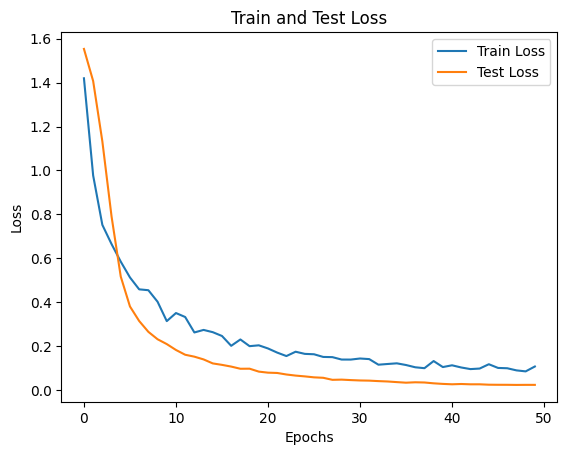

In [67]:
# Преобразование всех столбцов в числовой формат
def convert_to_numeric(df):
    for col in df.columns:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(int)
        elif df[col].dtype == 'object':
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                df[col] = pd.factorize(df[col])[0]
    return df

# Выделяем признаки и метки
X = df.drop(columns=['Potential Accident Level Encoded'])
y = df['Potential Accident Level Encoded']

# Преобразование всех данных в числовой формат
X = convert_to_numeric(X)

# Разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Преобразование меток классов в диапазон от 0 до num_classes-1
y_train = y_train - 1
y_test = y_test - 1

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Создание DataLoader для PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Определение модели нейронной сети
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)  # уменьшение размера скрытого слоя
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)
        self.dropout = nn.Dropout(0.6)  # увеличение dropout
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size // 2)

    def forward(self, x):
        out = self.fc1(x)
        out = self.batch_norm1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.batch_norm2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out

input_size = X_train.shape[1]
hidden_size = 128  # уменьшение скрытого слоя
num_classes = len(y.unique())

model = MLP(input_size, hidden_size, num_classes)

# Определение функции потерь и оптимизатора с L2-регуляризацией
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)  # уменьшение learning rate и увеличение weight decay

# Обучение модели с ранним прекращением
num_epochs = 50
train_losses = []
test_losses = []
best_test_loss = float('inf')
patience = 10  # Число эпох без улучшений перед остановкой
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_losses.append(train_loss / len(train_loader))

    # Проверка на тестовом наборе
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    # Раннее прекращение
    if test_losses[-1] < best_test_loss:
        best_test_loss = test_losses[-1]
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered.")
        break

# Оценка модели
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend((predicted + 1).numpy())  # Сдвиг предсказанных значений на +1
        y_true.extend((y_batch + 1).numpy())    # Сдвиг истинных значений на +1 для правильного сравнения

# Проверка на переобучение и недообучение
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Loss')
plt.show()

Сравним результаты.

In [68]:
# Оценка модели Gradient Boosting
# gb_report = classification_report(y_test, y_pred_gb, target_names=[f"{i+1}" for i in class_labels])
print("Gradient Boosting Classification Report:")
print(gb_report)

# Отчет о классификации
report = classification_report(y_true, y_pred)
print("Neural Network Classification Report:")
print(report)

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00        21
           4       1.00      1.00      1.00        29
           5       1.00      1.00      1.00         6

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85

Neural Network Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00        21
           4       1.00      1.00      1.00        29
           5       1.00      1.00      1.00         6

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        8

# Предобработка датасета для обучения. Вариант 3.

<h3>Для каждой строчки с описанием происшествия определим:</h3> 
<br>1. Должность.
<br>2. Действия, которые совершал работник.
<br>3. Инструменты и техника.

Добавим эти данные для каждой обработанной строки (создадим новые поля).

In [69]:
df = pd.read_csv('descr_cleaned_dataset.csv')
df.head(2)

,Genre,Employee or Third Party,Critical Risk,Month,Cleaned_Description,Potential Accident Level Encoded
0,Male,Third Party,Pressed,January,remove drill rod jumbo maintenance supervisor proceed loosen support intermediate centralizer facilitate removal see mechanic support end drill equipment pull hand bar accelerate removal this moment bar slide point support tighten finger mechanic drilling bar beam jumbo,4
1,Male,Employee,Pressurized Systems,January,activation sodium sulphide pump pipe uncoupled sulfide solution design area reach maid immediately use emergency shower direct ambulatory doctor later hospital note sulphide solution gram liter,4


In [70]:
# Создаем словарь с данными для таблицы
data = {
    "Должности": [
        "Auxiliary assistant, Collaborator, Clerk, Geologist, Safety technical, Mining technician, Mechanical, Danilo Silva, Technician.", 
        "Forklift operator, Collaborator, Operator, Chief guard, Assistant, Engineer trainee, Teacher, Store attendant, Welder, Topographic surveyor, Operator bolter, Technician, Mixkret operator, Geologist, Maintenance team, Mechanic, Surveying worker, Industrial cleaning worker, Food preparer, Mobile equipment maintenance team, Comedor worker.", 
        "Collaborator, Mechanic technician, Electrician supervisor, Master loader, Equipment assistant, Official operator, Assistant loader, Master shipper, Truck crane operator, Mechanic, Technician, Civil operator, Bolted assistant, Welder, Helper, Boltec technician, Sampler, Electrician, Operator, Mechanic operator.", 
        "Maintenance Supervisor, Mechanic, Driller assistant, Operator, Mason Assistant, Bolter Operator, Mill Operator, Assistant Mechanic, Welder, Technician, Truck Driver, Plant Worker, Blaster, Maintenance worker.", 
        "Mixkret operator, Resident engineer, Filter operator, Autoclave operator, Mechanic, Pilot, Mixer operator, Wheel loader operator, Operator of the concrete plant, Scalar operator."
    ],
    "Действия": [
        "Unlock, Identify hexagonal head, Climb platform, Exert pressure hand, Try unclog material, Detach project, Enable place winch control room, Get short walk slip, Sit floor, Make contact, Carry sediment collection, Run meter, Evaluate geological point, Give access area, Know drainage point, Strike sting weed neck, Perform soil collection activity, Attach wire, Perform magnetometric GPS, Use sunglass, Carry refractory brick, Chop activity, Place support bus bar section, Execute soil sample task, Open machete, Break magnetometer Antenna, Move acquisition line, Traverse drainage.", 
        "Cleaning metal structures, Operating a crane and forklift, Using a hammer and chisel, Releasing a blade and manually displacing sheets, Operating a truck and adjusting bolts, Cutting electro welded mesh, Opening access areas with tools, Welding and inspecting mining cars, Handling chemicals, Performing maintenance on various equipment, Using a torch for cutting activities, Loading and unloading materials, Preparing geological maps and conducting surveys, Painting floors, Carrying out inspections, Preparing food, Cleaning industrial areas, Handling ventilation equipment.", 
        "Excavation work, Unload operation, Unclog discharge mouth, Maneuver to unhook hose, Turn pulley manually, Grab transmission belt, Verify belt tension, Install segment of polyurethane pulley, Clean shutter with air lance, Perform truck unload operation, Remove rope tie, Perform disconnection of power cable, Detach upper support point, Verify remaining position, Identify rock mesh, Change drill bit, Release coupling, Replace telescopic expansion joint, Position portable ladder, Hold base of loader, Clean spatula spear window boiler, Perform radial drilling, Activate hydraulic pump inspection cover, Install support mesh cloth, Handle water supply hose, Verify lock failure, Dismantle scaffold, Perform carbon steel pipe mark activity, Perform maintenance on motor support, Place protective plate on fuel tank, Perform supply operation for zinc powder container, Perform maintenance activity on transmission belt, Test soft starter engine belt, Perform mechanical support activity, Conduct inspection of sulfuric acid spill line, Carry out sand electrolysis piece, Perform brushcutter operation, Handle pneumatic conveyor, Transport dust zinc container, Lower metal sheet, Assemble activity for polypropylene pipe, Clean area near conveyor, Move locomotive personnel, Perform drilling activity with LM17 probe, Remove bucket of pulp sample, Supervise ustulation activity, Carry inspection cut block level OB6A.", 
        "Loosening support, Facilitating removal, Tightening, Activating pump, Designing area, Applying aid, Positioning pot, Operating drill, Cleaning position, Securing pipe, Lifting platform, Aligning cathode press, Manually moving steel cabinet, Drilling hole, Removing flange, Applying shotcrete, Preparing oil cylinder, Mounting rail platform, Feeding bag into furnace, Supporting stabilizer, Conducting maintenance, Checking work front, Verifying ventilation, Placing mesh, Pulling support mesh, Unloading ore, Reshaping hand, Unlocking rod, Tightening bolt, Evaluating acid leakage, Unloading residual water, Operating equipment, Driving truck, Inspecting equipment, Removing suction pipe, Cleaning low floor, Wearing safety equipment, Entering filter belt, Preparing construction, Perform rock untie, Lift brace, Hoisting and setting up equipment, Changing fuses, Soil collection, Cleaning area, Installation of ventilation plug, Welding steel plate, Unloading material, Operating overflow system, Manipulating hose, Testing equipment.", 
        "Open the electric board, Proceed with the installation, Remove the lock, Use the thermomagnetic key, Make phase contact, Check voltage, Plug socket, Cut wire, Transfer pump, Clean pump, Manipulate motor pump transmission, Change cable, Start equipment, Stop equipment, Perform sanitation, Clean compressor, Lubricate equipment, Load explosive equipment, Putty work, Clean material, Change conveyor belt."
    ],
    "Инструменты и техника": [
        "Metal piece, Shovel, Bucket, Canvas, Wooden handle, Metallic hammer, Sickle, Electric cable, Magnetometric GPS, Antenna, Hammer, Rock, Machete, Refractor, Shovel, Tabola, Scaller breaker arm, Hand tool, Structure equipment, Magnetometer, Screen.", 
        "Forklift, Hammer and chisel, Ladder, Manual displacement tools, Truck (A30), Electro welded mesh cutter, Machete, Welding equipment, Mixing equipment, Loaders (e.g., J005A), Sludge lever, Shears, Scissor bolter, Mona car, Laboratory sampling tools, Chemical containers, Pressure hoses, Pumps and blowers, Mining and inspection tools, High-pressure pump gun, Shovels and cleaning tools, Power cables and sockets, Cathode cranes, Zinc sheets, Wooden stumps, Rail tracks and corridors, Industrial cleaning equipment, Soil activity tools (e.g., pickaxe).", 
        "Ustilago powder, Silo truck, Transmission belt HM pump, Polyurethane pulley, Electro welded mesh, Hydraulic cylinder, Winch pulley, Air lance, Telescopic ladder, Metal bar hammer, Telescopic expansion joint HDPE pipe, Spatula spear window boiler, Simba M4C ITH equipment, Hydraulic pump, Volumetric balloon, Radial drilling machine, Scissor bolter, HDPE pipe storm drainage system, POM D071 return thickener, LM17 probe, Iron bundle truck, Breaker tip, Jumbo drilling rig, Stilson key, Tire lever, Sledgehammer, Doosan RB equipment, Combination wrench, Hydraulic load maintenance equipment, Mechanized support scissor, Shotcrete gun, Three-way pear pipette, Nitrogen hose, Hydraulic fill pipe.", 
        "Drill rod, Jumbo, Sodium sulphide pump, Hand bar, Pulley motor, Oil cylinder, Scaffold, Truck, Bolt, Drilling machine, Stilson key, Steel wire rope, Winch, Jack, Suction valve, Cable pump, Locomotive, Electrical system, Shotcrete equipment, Ingot rotary table, Air lance, Concrete throwing team, Geho pump, Metal rake, Hydraulic hammer, Chisel, Lubricant, Strip set, Mining car, Diamond drill, Fisherman winch cable, Calibrator, Welding equipment, Peristaltic pump, Tirfor, Autoclave, Conveyor belt, Ventilation plug, Cleaning mechanism, Water hose, Manipulator, Stone cutting machine, Scoop lip, Hoist, Jackleg.", 
        "Split set intersection, Electric board 440V 400A, Thermomagnetic key, Panel shell, Mixkret, Autoclave, Anfo loader, Dumper, Pump, Automatic sampler, Platform, Wheel loader, Manual tick, Hydraulic fill, Intermediate cardan protector, Lamp, Motor transmission belt, Compressor, Cross cutter, Conveyor belt, Suction spool, Scrubber, Hydraulic cylinder, Vibrator, Scoop, Electric cable, PVC pipe, Fan belt, Key, Hose, Shotcrete."
    ],
}

# Добавление новых колонок
df['Positions'] = ""
df['Actions'] = ""
df['Tools_and_equipment'] = ""

In [71]:
# Проверка наличия строк с Potential Accident Level Encoded = 6
count_6 = df[df['Potential Accident Level Encoded'] == 6].shape[0]
print(f'Количество строк с Potential Accident Level Encoded = 6: {count_6}')

# Удаление всех строк с Potential Accident Level Encoded = 6
df = df[df['Potential Accident Level Encoded'] != 6]

# Проверка количества строк после удаления
print(f'Количество строк после удаления: {df.shape[0]}')

# Проверка информации о DataFrame
print(df.info())

Количество строк с Potential Accident Level Encoded = 6: 1
Количество строк после удаления: 424
<class 'pandas.core.frame.DataFrame'>
Index: 424 entries, 0 to 424
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Genre                             424 non-null    object
 1   Employee or Third Party           424 non-null    object
 2   Critical Risk                     424 non-null    object
 3   Month                             424 non-null    object
 4   Cleaned_Description               424 non-null    object
 5   Potential Accident Level Encoded  424 non-null    int64 
 6   Positions                         424 non-null    object
 7   Actions                           424 non-null    object
 8   Tools_and_equipment               424 non-null    object
dtypes: int64(1), object(8)
memory usage: 33.1+ KB
None


In [72]:
# Функция для поиска и заполнения данных из словаря по уровню происшествия без учета регистра
def fill_columns_by_level(description, level, data):
    positions = data["Должности"][level-1]
    actions = data["Действия"][level-1]
    tools_and_equipment = data["Инструменты и техника"][level-1]
    
    description = description.lower()
    
    found_positions = [term for term in positions.split(", ") if re.search(r'\b' + re.escape(term.lower()) + r'\b', description)]
    found_actions = [term for term in actions.split(", ") if re.search(r'\b' + re.escape(term.lower()) + r'\b', description)]
    found_tools_and_equipment = [term for term in tools_and_equipment.split(", ") if re.search(r'\b' + re.escape(term.lower()) + r'\b', description)]

    return ", ".join(found_positions), ", ".join(found_actions), ", ".join(found_tools_and_equipment)

# Применение функции к каждой строке
for index, row in df.iterrows():
    level = row['Potential Accident Level Encoded']
    if level in [1, 2, 3, 4, 5]:
        positions, actions, tools_and_equipment = fill_columns_by_level(row['Cleaned_Description'], level, data)
        df.loc[index, 'Positions'] = positions
        df.loc[index, 'Actions'] = actions
        df.loc[index, 'Tools_and_equipment'] = tools_and_equipment

# Сохранение нового датасета в файл
df.to_csv('df_pos_act_tools.csv', index=False)

print("Новый датасет сохранен в файл 'df_pos_act_tools.csv'.")

Новый датасет сохранен в файл 'df_pos_act_tools.csv'.


In [73]:
df = pd.read_csv('df_pos_act_tools.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Genre                             424 non-null    object
 1   Employee or Third Party           424 non-null    object
 2   Critical Risk                     424 non-null    object
 3   Month                             424 non-null    object
 4   Cleaned_Description               424 non-null    object
 5   Potential Accident Level Encoded  424 non-null    int64 
 6   Positions                         170 non-null    object
 7   Actions                           40 non-null     object
 8   Tools_and_equipment               116 non-null    object
dtypes: int64(1), object(8)
memory usage: 29.9+ KB


Видим, что не все данные заполнились.

<h3>Дозаполним пустые данные вручную, проанализировав каждое описание происшествия. Соохраним полученные данные в новый датасет df_pos_act_tools_manual_processing.csv</h3>

In [74]:
df = pd.read_csv('df_pos_act_tools_manual_processing_2.csv', sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424 entries, 0 to 423
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Genre                             424 non-null    object
 1   Employee or Third Party           424 non-null    object
 2   Critical Risk                     424 non-null    object
 3   Month                             424 non-null    object
 4   Cleaned_Description               424 non-null    object
 5   Potential Accident Level Encoded  424 non-null    int64 
 6   Positions                         424 non-null    object
 7   Actions                           424 non-null    object
 8   Tools_and_equipment               424 non-null    object
dtypes: int64(1), object(8)
memory usage: 29.9+ KB


In [75]:
# # Удаление колонки "Cleaned_Description"
# df = df.drop(columns=['Cleaned_Description'])

In [76]:
df.head(2)

,Genre,Employee or Third Party,Critical Risk,Month,Cleaned_Description,Potential Accident Level Encoded,Positions,Actions,Tools_and_equipment
0,Male,Third Party,Pressed,January,remove drill rod jumbo maintenance supervisor proceed loosen support intermediate centralizer facilitate removal see mechanic support end drill equipment pull hand bar accelerate removal this moment bar slide point support tighten finger mechanic drilling bar beam jumbo,4,"Maintenance Supervisor, Mechanic","Remove, Proceed, Loosen, Facilitate","Drill rod, Jumbo, Hand bar"
1,Male,Employee,Pressurized Systems,January,activation sodium sulphide pump pipe uncoupled sulfide solution design area reach maid immediately use emergency shower direct ambulatory doctor later hospital note sulphide solution gram liter,4,Maid,"Reach, Use",Sodium sulphide pump


In [77]:
# Функция для приведения текста к нижнему регистру и удаления пунктуации
def preprocess_text(text):
    # Приведение к нижнему регистру
    text = text.lower()
    # Удаление пунктуации
    text = re.sub(r'[^\w\s]', '', text)
    return text

# Применение функции к нужным колонкам
columns_to_preprocess = ['Positions', 'Actions', 'Tools_and_equipment']
for column in columns_to_preprocess:
    df[column] = df[column].apply(preprocess_text)

In [78]:
# Проверка результата
df.head()

,Genre,Employee or Third Party,Critical Risk,Month,Cleaned_Description,Potential Accident Level Encoded,Positions,Actions,Tools_and_equipment
0,Male,Third Party,Pressed,January,remove drill rod jumbo maintenance supervisor proceed loosen support intermediate centralizer facilitate removal see mechanic support end drill equipment pull hand bar accelerate removal this moment bar slide point support tighten finger mechanic drilling bar beam jumbo,4,maintenance supervisor mechanic,remove proceed loosen facilitate,drill rod jumbo hand bar
1,Male,Employee,Pressurized Systems,January,activation sodium sulphide pump pipe uncoupled sulfide solution design area reach maid immediately use emergency shower direct ambulatory doctor later hospital note sulphide solution gram liter,4,maid,reach use,sodium sulphide pump
2,Male,Third Party (Remote),Manual Tools,January,substation milpo locate level collaborator excavation work pick hand tool hit rock flat beak bounce hit steel tip safety shoe metatarsal area ​​the left foot collaborator cause injury,3,collaborator,excavation work,hand tool
3,Male,Third Party,Others,January,be approximately nv cx ob7 personnel begin task unlock soquet bolt bhb machine penultimate bolt identify hexagonal head wear proceed mr auxiliary assistant climb platform exert pressure hand dado key prevent come bolt moment collaborator rotate lever anticlockwise direction leave key bolt hit palm leave hand cause injury,1,auxiliary assistant collaborator,unlock identify hexagonal head climb platform exert pressure hand,soquet bolt bhb machine dado key hexagonal head lever
4,Male,Third Party,Others,January,approximately be circumstance mechanic group leader the company impromec perform removal pulley motor pump zaf marcy length weight kg lock proceed heating pulley loosen it come falls distance meter high hit instep right foot Employee cause injury describe,4,mechanic,perform removal lock proceed heating loosen,pulley motor


In [79]:
# Применение One-Hot Encoding к категориальным столбцам
df = pd.get_dummies(df, columns=['Genre', 'Employee or Third Party', 'Critical Risk', 'Month'])

# Векторизация текста с использованием TF-IDF для Cleaned_Description, Positions, Actions, Tools_and_equipment
tfidf = TfidfVectorizer(max_features=10000)

# Векторизация для каждого текстового столбца и объединение результатов
# for column in ['Cleaned_Description', 'Positions', 'Actions', 'Tools_and_equipment']:
for column in ['Cleaned_Description', 'Positions', 'Actions', 'Tools_and_equipment']:
    X_tfidf = tfidf.fit_transform(df[column])
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=[f"{column}_{feature}" for feature in tfidf.get_feature_names_out()])
    df = pd.concat([df.drop(columns=[column]), X_tfidf_df], axis=1)

In [80]:
# Создание копии DataFrame
df_copy = df.copy()
df_copy.head(2)

Potential Accident Level Encoded  Genre_Female  Genre_Male  \
0                                 4         False        True   
1                                 4         False        True   

   Employee or Third Party_Employee  Employee or Third Party_Third Party  \
0                             False                                 True   
1                              True                                False   

   Employee or Third Party_Third Party (Remote)  \
0                                         False   
1                                         False   

   Critical Risk_\nNot applicable  Critical Risk_Bees  \
0                           False               False   
1                           False               False   

   Critical Risk_Blocking and isolation of energies  Critical Risk_Burn  \
0                                             False               False   
1                                             False               False   

   Critical Risk_Chemical substances  Critical Risk_Confined space  \
0                              False                         False   
1                              False                         False   

   Critical Risk_Cut  Critical Risk_Electrical Shock  \
0              False                           False   
1              False                           False   

   Critical Risk_Electrical installation  Critical Risk_Fall  \
0                                  False               False   
1                                  False               False   

   Critical Risk_Fall prevention  Critical Risk_Fall prevention (same level)  \
0                          False                                       False   
1                          False                                       False   

   Critical Risk_Individual protection equipment  Critical Risk_Liquid Metal  \
0                                          False                       False   
1                                          False                       False   

   Critical Risk_Machine Protection  Critical Risk_Manual Tools  \
0                             False                       False   
1                             False                       False   

   Critical Risk_Others  Critical Risk_Plates  Critical Risk_Poll  \
0                 False                 False               False   
1                 False                 False               False   

   Critical Risk_Power lock  Critical Risk_Pressed  \
0                     False                   True   
1                     False                  False   

   Critical Risk_Pressurized Systems  \
0                              False   
1                               True   

   Critical Risk_Pressurized Systems / Chemical Substances  \
0                                                    False   
1                                                    False   

   Critical Risk_Projection  Critical Risk_Projection of fragments  \
0                     False                                  False   
1                     False                                  False   

   Critical Risk_Projection/Burning  Critical Risk_Projection/Choco  \
0                             False                           False   
1                             False                           False   

   Critical Risk_Projection/Manual Tools  Critical Risk_Suspended Loads  \
0                                  False                          False   
1                                  False                          False   

   Critical Risk_Traffic  Critical Risk_Vehicles and Mobile Equipment  \
0                  False                                        False   
1                  False                                        False   

   Critical Risk_Venomous Animals  Critical Risk_remains of choco  \
0                           False                           False   
1                           False                           False   

   Month_Ap

In [81]:
# Выделяем признаки и метки
X = df.drop(columns=['Potential Accident Level Encoded'])
y = df['Potential Accident Level Encoded']

# Разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

# Обучение. Градиентный бустинг. Вариант 3.

In [82]:
# Определение гиперпараметров для подбора
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5]
}

# Настройка GridSearchCV
gb_clf = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb_clf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')

# Обучение модели с подбором гиперпараметров
grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Оценка модели с лучшими параметрами
best_gb_clf = grid_search.best_estimator_
y_pred_gb = best_gb_clf.predict(X_test)

gb_report = classification_report(y_test, y_pred_gb, target_names=[f"{i+1}" for i in class_labels])

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}


Epoch 1/50, Train Loss: 1.7318, Test Loss: 1.5898
Epoch 2/50, Train Loss: 1.6062, Test Loss: 1.5666
Epoch 3/50, Train Loss: 1.4794, Test Loss: 1.5460
Epoch 4/50, Train Loss: 1.3628, Test Loss: 1.5220
Epoch 5/50, Train Loss: 1.2363, Test Loss: 1.4907
Epoch 6/50, Train Loss: 1.2111, Test Loss: 1.4569
Epoch 7/50, Train Loss: 1.1498, Test Loss: 1.4231
Epoch 8/50, Train Loss: 1.0480, Test Loss: 1.4062
Epoch 9/50, Train Loss: 0.9759, Test Loss: 1.3917
Epoch 10/50, Train Loss: 0.9641, Test Loss: 1.3808
Epoch 11/50, Train Loss: 0.8986, Test Loss: 1.3774
Epoch 12/50, Train Loss: 0.8680, Test Loss: 1.3664
Epoch 13/50, Train Loss: 0.7597, Test Loss: 1.3597
Epoch 14/50, Train Loss: 0.6969, Test Loss: 1.3478
Epoch 15/50, Train Loss: 0.7409, Test Loss: 1.3406
Epoch 16/50, Train Loss: 0.6771, Test Loss: 1.3332
Epoch 17/50, Train Loss: 0.6224, Test Loss: 1.3327
Epoch 18/50, Train Loss: 0.5848, Test Loss: 1.3260
Epoch 19/50, Train Loss: 0.5523, Test Loss: 1.3202
Epoch 20/50, Train Loss: 0.5323, Test Lo

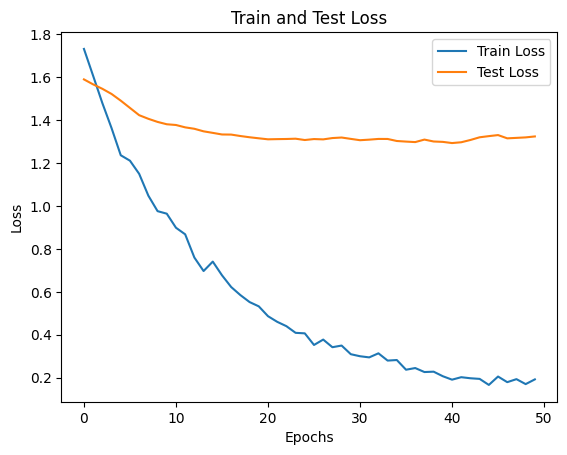

In [83]:
# Преобразование всех столбцов в числовой формат
def convert_to_numeric(df):
    for col in df.columns:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(int)
        elif df[col].dtype == 'object':
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                df[col] = pd.factorize(df[col])[0]
    return df

# Выделяем признаки и метки
X = df.drop(columns=['Potential Accident Level Encoded'])
y = df['Potential Accident Level Encoded']

# Преобразование всех данных в числовой формат
X = convert_to_numeric(X)

# Разбиение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Преобразование меток классов в диапазон от 0 до num_classes-1
y_train = y_train - 1
y_test = y_test - 1

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Создание DataLoader для PyTorch
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Определение модели нейронной сети
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)  # уменьшение размера скрытого слоя
        self.fc3 = nn.Linear(hidden_size // 2, num_classes)
        self.dropout = nn.Dropout(0.6)  # увеличение dropout
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size // 2)

    def forward(self, x):
        out = self.fc1(x)
        out = self.batch_norm1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.batch_norm2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc3(out)
        return out

input_size = X_train.shape[1]
hidden_size = 128  # уменьшение скрытого слоя
num_classes = len(y.unique())

model = MLP(input_size, hidden_size, num_classes)

# Определение функции потерь и оптимизатора с L2-регуляризацией
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.01)  # уменьшение learning rate и увеличение weight decay

# Обучение модели с ранним прекращением
num_epochs = 50
train_losses = []
test_losses = []
best_test_loss = float('inf')
patience = 10  # Число эпох без улучшений перед остановкой
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_losses.append(train_loss / len(train_loader))

    # Проверка на тестовом наборе
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()
    
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

    # Раннее прекращение
    if test_losses[-1] < best_test_loss:
        best_test_loss = test_losses[-1]
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered.")
        break

# Оценка модели
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend((predicted + 1).numpy())  # Сдвиг предсказанных значений на +1
        y_true.extend((y_batch + 1).numpy())    # Сдвиг истинных значений на +1 для правильного сравнения

# Проверка на переобучение и недообучение
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Test Loss')
plt.show()

Сравним результаты.

In [84]:
# Оценка модели Gradient Boosting
# gb_report = classification_report(y_test, y_pred_gb, target_names=[f"{i+1}" for i in class_labels])
print("Gradient Boosting Classification Report:")
print(gb_report)

# Отчет о классификации
report = classification_report(y_true, y_pred)
print("Neural Network Classification Report:")
print(report)

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.50      0.50        10
           2       0.35      0.37      0.36        19
           3       0.41      0.33      0.37        21
           4       0.50      0.62      0.55        29
           5       1.00      0.33      0.50         6

    accuracy                           0.46        85
   macro avg       0.55      0.43      0.46        85
weighted avg       0.48      0.46      0.45        85

Neural Network Classification Report:
              precision    recall  f1-score   support

           1       0.88      0.70      0.78        10
           2       0.40      0.53      0.45        19
           3       0.44      0.52      0.48        21
           4       0.54      0.45      0.49        29
           5       0.67      0.33      0.44         6

    accuracy                           0.51        85
   macro avg       0.58      0.51      0.53        8

# Сравним итоговые результаты.

![SNOWFALL](comparison.png)

<b>Вывод:</b>

<b>Анализ Gradient Boosting:</b> Вариант 3 демонстрирует улучшенные результаты по всем метрикам по сравнению с Вариантом 1. Увеличение точности, F1-оценки и значения Recall указывает на то, что Вариант 3 более эффективен в классификации и лучше справляется с задачей.

<b>Анализ Neural Network:</b> Вариант 3 также демонстрирует улучшение по сравнению с Вариантом 1, однако разница в результатах между двумя вариантами меньшая, чем у Gradient Boosting. Тем не менее, Вариант 3 лучше в точности и Recall по сравнению с Вариантом 1.

Отдельно стоит отметить, что описание происшествий очень сильно разрозненные и практически не похожи друг на друга за некоторыми исключениями.

<b>P.S. Тестовый запуск.</b>

In [85]:
data_employee = {
    # 'Name': ['Ivanov Ivan Ivanovich'],
    'Genre': ['Male'],
    'Employee or Third Party': ['Employee'],
    'Critical Risk': ['Power lock'], # 5 уровень
    'Positions': ['Assistant'], # 1,2 уровень
    'Actions': ['Identify hexagonal head.'], # 1 уровень
    'Tools_and_equipment': ['Hydraulic pump.'], # 3 уровень
    'Cleaned_Description': ['Make sure that the equipment is fully ready to install the 4 detachable kits. Make sure that the operator is ready to supply power to your equipment. Remove the lock and open the electrical panel designed for 220 V and 200 A. Check that all tools and protective equipment are in good condition and ready for use. Lift the thermomagnetic wrench with extreme care. Please note that when lifting the thermomagnetic key, phase contact with the ground on the panel may occur. In case of contact of the phase with the ground on the panel, a flash may occur that can reach the operator. Take all necessary safety measures to prevent injury and damage. Use appropriate personal protective equipment (PPE).']  # 5 уровень
}

df_employee = pd.DataFrame(data_employee)

# Применение One-Hot Encoding к категориальным столбцам
df_employee = pd.get_dummies(df_employee, columns=['Genre', 'Employee or Third Party', 'Critical Risk'])

# Применение TF-IDF к текстовым столбцам
tfidf_dfs = []
for column in ['Cleaned_Description', 'Positions', 'Actions', 'Tools_and_equipment']:
    X_tfidf = tfidf.transform(df_employee[column])
    tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=[f"{column}_{feature}" for feature in tfidf.get_feature_names_out()])
    tfidf_dfs.append(tfidf_df)

# Объединение TF-IDF столбцов и удаление исходных текстовых столбцов
df_employee = pd.concat([df_employee.drop(columns=['Cleaned_Description', 'Positions', 'Actions', 'Tools_and_equipment'])] + tfidf_dfs, axis=1)

# Преобразование всех данных в числовой формат
df_employee = convert_to_numeric(df_employee)

# Заполнение отсутствующих столбцов нулями и упорядочивание столбцов согласно обучающему набору данных
missing_columns = list(set(X.columns) - set(df_employee.columns))
missing_df = pd.DataFrame(0, index=df_employee.index, columns=missing_columns)
df_employee = pd.concat([df_employee, missing_df], axis=1)

# Упорядочивание столбцов
df_employee = df_employee[X.columns]

# Преобразование данных в тензоры
X_employee_tensor = torch.tensor(df_employee.values, dtype=torch.float32)

# Прогноз
with torch.no_grad():
    output = model(X_employee_tensor)
    _, predicted = torch.max(output, 1)
    predicted_class = predicted.item() + 1  # Сдвиг на +1, чтобы вернуть исходные классы

print(f"Predicted class: {predicted_class}")

Predicted class: 3
